# Data Exploration

In [1]:
import logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(level=logging.INFO)

logger = logging.getLogger('baseline')

In [2]:
def json_to_df(json_file=None):
    """ Reads a single JSON file containing the
    shipment information and converts it to a
    structured dataframe
    """
    import pandas as pd
    from pandas.io.json import json_normalize
    import numpy as np
    logger.debug("Converting to dataframe: {}".format(json_file))
    df = pd.read_json(json_file, dtype={"shipment_number": str})
    normalized_df = json_normalize(df['events'])
    df.drop(["events"], axis=1, inplace=True)
    df = pd.concat([df, normalized_df], axis=1)
    if "Die Sendung wurde elektronisch angeku00FCndigt. Sobald die Sendung von uns bearbeitet wurde, erhalten Sie weitere Informationen." == df.tail(1)["status"].item():
        logger.warning("Final delivery state is strange! Ignoring the file {}".format(json_file))
        return
    # Some files have multiple states. It does not make sense!
    if df[df["status"] == "Die Sendung wurde erfolgreich zugestellt."].shape[0] > 1:
        logger.warning("Multiple final states! Ignoring the file {}".format(json_file))
        return
    if df["status"].isnull().any():
        logger.warning("Status column has missing values! Ignoring the file {}".format(json_file))
        return
    if len(df["url"].unique()) > 1:
        logger.warning("Multiple URLs for a single shipment number! Something is wrong")
    if len(df["shipment_number"].unique()) > 1:
        logger.warning("Multiple shipment numbers in the same file. Something is wrong")
    df['crawltime'] = pd.to_datetime(df['crawltime'], utc=True)
    df['datum'] = pd.to_datetime(df['datum'], utc=True)
    if df["status"].isnull().values.any():
        logger.warning("Column status has missing values! ShipmentNumber: {}".format(df["shipment_number"].values[0]))
    final_event_array = np.zeros(len(df))
    final_event_array[-1] = 1
    df["is_final_event"] = final_event_array
    return df

In [3]:
def files_to_df(path='../data'):
    """ Convert all files to a single dataframe
    """
    import os
    import pandas as pd
    files = []
    for r, d, f in os.walk(path):
        for file in f:
            if '.json' in file:
                files.append(os.path.join(r, file))
    dfs = [json_to_df(json_file=file) for file in files]
    df = pd.concat(dfs, sort=False)
    return df

In [4]:
df = files_to_df(path='../data')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: `item` has been deprecated and will be removed in a future version
  


### Are there any missing values?

In [5]:
import pandas as pd
def count_missing_values(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
    return missing_value_df
missing_value_df = count_missing_values(df)

In [6]:
missing_value_df

,column_name,percent_missing
shipment_number,shipment_number,0.000000
crawltime,crawltime,0.000000
url,url,0.000000
datum,datum,0.000000
status,status,0.000000
ort,ort,59.157816
is_final_event,is_final_event,0.000000


Column "ort" has many missing values. We fill them with "Unbekannt"

In [7]:
def fill_missing_values(df):
    """ Fills missing values of specific columns
    in the data frame with pre-defined values.
    """
    df['ort'].fillna("Unbekannt", inplace=True)
    logger.debug("Filled missing values for ort column")
    return df

In [8]:
df = fill_missing_values(df)

Check again if there are any missing values

In [9]:
count_missing_values(df)

,column_name,percent_missing
shipment_number,shipment_number,0.0
crawltime,crawltime,0.0
url,url,0.0
datum,datum,0.0
status,status,0.0
ort,ort,0.0
is_final_event,is_final_event,0.0


### Data Stats

In [10]:
df.shape

(5367, 7)

Number of unique shipment numbers

In [11]:
len(df.shipment_number.unique())

964

### Investigate Data Types

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5367 entries, 0 to 5
Data columns (total 7 columns):
shipment_number    5367 non-null object
crawltime          5367 non-null datetime64[ns, UTC]
url                5367 non-null object
datum              5367 non-null datetime64[ns, UTC]
status             5367 non-null object
ort                5367 non-null object
is_final_event     5367 non-null float64
dtypes: datetime64[ns, UTC](2), float64(1), object(4)
memory usage: 335.4+ KB


Everything regarding data types seems to be fine! No need for conversion

### Prepare data for exploration and machine learning

- Given the features "datum", "status" and "ort" we want to predict the next "datum" and hopefully also the next "status" and the next "ort"
- We create 3 new columns. "datum_next", "ort_next" and "status_next".

In [13]:
def create_target_columns(df):
    import numpy as np 

    df['status_next'] = df.groupby(['shipment_number'])['status'].shift(-1)
    df['ort_next'] = df.groupby(['shipment_number'])['ort'].shift(-1)
    df['datum_next'] = df.groupby(['shipment_number'])['datum'].shift(-1)
    # we define values for the case the package is already delivered.
    df.loc[df['is_final_event'] == 1, 'status_next'] = "SuccessDelivery"
    df.loc[df['is_final_event'] == 1, 'ort_next'] = "SuccessDelivery"
    df.loc[df['is_final_event'] == 1, 'datum_next'] = np.datetime64('today')
    
    return df

In [14]:
# Disable warnings
pd.set_option('mode.chained_assignment', None)
df = create_target_columns(df)

In [15]:
df.head()

,shipment_number,crawltime,url,datum,status,ort,is_final_event,status_next,ort_next,datum_next
0,00340434188193325701,2019-12-03 09:59:25+00:00,https://www.dhl.de/int-verfolgen/search?langua...,2019-10-08 14:42:00+00:00,Die Sendung wurde elektronisch angeku00FCndigt...,Unbekannt,0.0,Die Sendung wurde von DHL bearbeitet und wird ...,Hamburg,2019-10-08 18:19:00
1,00340434188193325701,2019-12-03 09:59:25+00:00,https://www.dhl.de/int-verfolgen/search?langua...,2019-10-08 18:19:00+00:00,Die Sendung wurde von DHL bearbeitet und wird ...,Hamburg,0.0,Die Sendung ist in der Region des Empfu00E4nge...,Saulheim,2019-10-09 02:44:00
2,00340434188193325701,2019-12-03 09:59:25+00:00,https://www.dhl.de/int-verfolgen/search?langua...,2019-10-09 02:44:00+00:00,Die Sendung ist in der Region des Empfu00E4nge...,Saulheim,0.0,Die Sendung wurde in das Zustellfahrzeug gelad...,Unbekannt,2019-10-09 07:46:00
3,00340434188193325701,2019-12-03 09:59:25+00:00,https://www.dhl.de/int-verfolgen/search?langua...,2019-10-09 07:46:00+00:00,Die Sendung wurde in das Zustellfahrzeug gelad...,Unbekannt,0.0,Die Sendung wurde erfolgreich zugestellt.,Unbekannt,2019-10-09 10:35:00
4,00340434188193325701,2019-12-03 09:59:25+00:00,https://www.dhl.de/int-verfolgen/search?langua...,2019-10-09 10:35:00+00:00,Die Sendung wurde erfolgreich zugestellt.,Unbekannt,1.0,SuccessDelivery,SuccessDelivery,2019-12-04 00:00:00


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5367 entries, 0 to 5
Data columns (total 10 columns):
shipment_number    5367 non-null object
crawltime          5367 non-null datetime64[ns, UTC]
url                5367 non-null object
datum              5367 non-null datetime64[ns, UTC]
status             5367 non-null object
ort                5367 non-null object
is_final_event     5367 non-null float64
status_next        5367 non-null object
ort_next           5367 non-null object
datum_next         5367 non-null datetime64[ns]
dtypes: datetime64[ns, UTC](2), datetime64[ns](1), float64(1), object(6)
memory usage: 461.2+ KB


### Data Stats

In [17]:
count_missing_values(df)

,column_name,percent_missing
shipment_number,shipment_number,0.0
crawltime,crawltime,0.0
url,url,0.0
datum,datum,0.0
status,status,0.0
ort,ort,0.0
is_final_event,is_final_event,0.0
status_next,status_next,0.0
ort_next,ort_next,0.0
datum_next,datum_next,0.0


In [18]:
df.shape

(5367, 10)

Number of unique shipment numbers

In [19]:
len(df.shipment_number.unique())

964

In [20]:
len(df.status.unique())

132

In [21]:
len(df.ort.unique())

129

### How many different final delivery states exist?

In [22]:
final_delivery_states = df.groupby(['shipment_number']).tail(1)[["status"]]["status"].unique()
print(final_delivery_states)

['Die Sendung wurde erfolgreich zugestellt.'
 'Der Empfu00E4nger hat die Sendung aus der PACKSTATION abgeholt.'
 'Der Empfu00E4nger hat die Sendung in der Filiale abgeholt.'
 'Die Sendung konnte nicht zugestellt werden und wird in eine Packstation gebracht.']


### How many different initial delivery states exist?

In [23]:
initial_delivery_states = df.groupby(['shipment_number']).head(1)[["status"]]["status"].unique()
print(initial_delivery_states)

['Die Sendung wurde elektronisch angeku00FCndigt. Sobald die Sendung von uns bearbeitet wurde, erhalten Sie weitere Informationen.'
 'Die Sendung wurde von DHL bearbeitet und wird fu00FCr den Weitertransport in die Region des Empfu00E4ngers vorbereitet.'
 'Die Sendung wird fu00FCr den Weitertransport vorbereitet.']


### Distribution of final delivery states

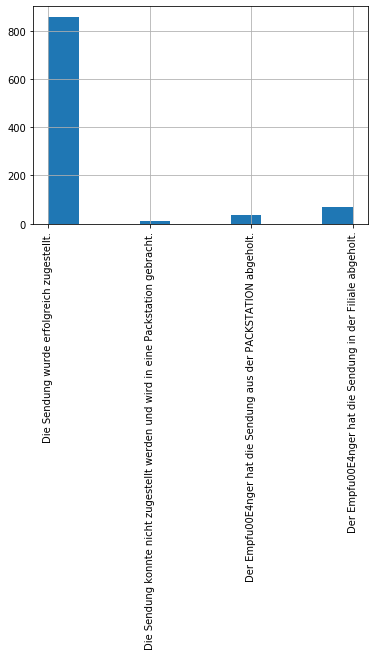

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.xticks(rotation='vertical')

df[df["status"].isin(final_delivery_states)]["status"].hist()

### Distribution of initial states

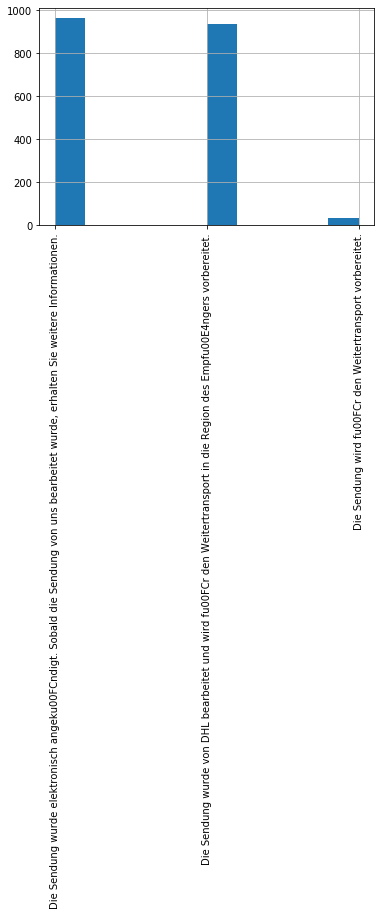

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.xticks(rotation='vertical')

df[df["status"].isin(initial_delivery_states)]["status"].hist()

### Distribution of all states

These are the most common states

In [26]:
pd.DataFrame(df["status"].value_counts()).head(10)

,status
Die Sendung wurde in das Zustellfahrzeug geladen. Die Zustellung erfolgt voraussichtlich heute.,991
Die Sendung ist in der Region des Empfu00E4ngers angekommen und wird im nu00E4chsten Schritt zur Zustellbasis transportiert.,975
"Die Sendung wurde elektronisch angeku00FCndigt. Sobald die Sendung von uns bearbeitet wurde, erhalten Sie weitere Informationen.",964
Die Sendung wurde von DHL bearbeitet und wird fu00FCr den Weitertransport in die Region des Empfu00E4ngers vorbereitet.,936
Die Sendung wurde erfolgreich zugestellt.,859
Die Sendung wird fu00FCr die Verladung ins Zustellfahrzeug vorbereitet.,204
Der Empfu00E4nger hat die Sendung in der Filiale abgeholt.,68
Die Sendung konnte nicht zugestellt werden und wird in die Filiale gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich.,62
Der Empfu00E4nger hat die Sendung aus der PACKSTATION abgeholt.,36
Die Sendung wird fu00FCr den Weitertransport vorbereitet.,35


These are the least common states. What we see here is that there are some states that are basically the same and the following pattern:

"Die Sendung liegt in der ........ zur Abholung bereit"

But the address is each time different. This leads to too many states, which also makes machine learning hard. We ignore the address part and convert all these states to a single one.

In [27]:
pd.DataFrame(df["status"].value_counts()).tail(10)

,status
"Die Sendung wird zur Abholung in die &lt;a href='https://psf.dhl.com/?countrycode=DEu0026address=Greifswald%2C+Hansestadt Lomonossowallee 58' class='arrowLink' target='_blank'&gt;&lt;span class='arrow'&gt;&lt;/span&gt;Filiale Greifswald, Hansestadt Lomonossowallee 58&lt;/a&gt; gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich.",1
Die Zustellung am gewu00FCnschten Liefertag 21.11.2019 wurde gewu00E4hlt.,1
Die Sendung wird zur Abholung in die &lt;a href='https://psf.dhl.com/?countrycode=DEu0026address=Reutlingen Gustav-Schwab-Str. 41' class='arrowLink' target='_blank'&gt;&lt;span class='arrow'&gt;&lt;/span&gt;Filiale Reutlingen Gustav-Schwab-Str. 41&lt;/a&gt; gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich.,1
Die Sendung wird zur Abholung in die &lt;a href='https://psf.dhl.com/?countrycode=DEu0026address=Ratzeburg Heinrich-Hertz-Str. 1b' class='arrowLink' target='_blank'&gt;&lt;span class='arrow'&gt;&lt;/span&gt;Filiale Ratzeburg Heinrich-Hertz-Str. 1b&lt;/a&gt; gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich.,1
Die Sendung liegt in der &lt;a href='https://psf.dhl.com/?countrycode=DEu0026address=Berlin Wendenschlo%C3%9Fstr. 354-3' class='arrowLink' target='_blank'&gt;&lt;span class='arrow'&gt;&lt;/span&gt;PACKSTATION 452 Wendenschlou00DFstr. 354-3 12557 Berlin&lt;/a&gt; zur Abholung bereit.,1
Die Sendung wird zur Abholung in die &lt;a href='https://psf.dhl.com/?countrycode=DEu0026address=Freiburg+im+Breisgau Markgrafenstr. 11' class='arrowLink' target='_blank'&gt;&lt;span class='arrow'&gt;&lt;/span&gt;Filiale Freiburg im Breisgau Markgrafenstr. 11&lt;/a&gt; gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich.,1
Die Sendung wird zur Abholung in die &lt;a href='https://psf.dhl.com/?countrycode=DEu0026address=Oberhausen Ramgestr. 11' class='arrowLink' target='_blank'&gt;&lt;span class='arrow'&gt;&lt;/span&gt;Filiale Oberhausen Ramgestr. 11&lt;/a&gt; gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich.,1
Die Sendung wird zur Abholung in die &lt;a href='https://psf.dhl.com/?countrycode=DEu0026address=Kerpen K%C3%B6lner+Str. 1' class='arrowLink' target='_blank'&gt;&lt;span class='arrow'&gt;&lt;/span&gt;Filiale Kerpen Ku00F6lner Str. 1&lt;/a&gt; gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich.,1
Die Sendung wird zur Abholung in die &lt;a href='https://psf.dhl.com/?countrycode=DEu0026address=Kassel Bremer+Str. 20' class='arrowLink' target='_blank'&gt;&lt;span class='arrow'&gt;&lt;/span&gt;Filiale Kassel Bremer Str. 20&lt;/a&gt; gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich.,1
Die Sendung wird zur Abholung in die &lt;a href='https://psf.dhl.com/?countrycode=DEu0026address=Zierenberg Poststr. 50' class='arrowLink' target='_blank'&gt;&lt;span class='arrow'&gt;&lt;/span&gt;Filiale Zierenberg Poststr. 50&lt;/a&gt; gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich.,1


In [28]:
df.loc[(df['status'].str.startswith("Die Sendung liegt in der")) & (df['status'].str.endswith("zur Abholung bereit.")), "status"] = "Die Sendung liegt in der ... zur Abholung bereit." 
df.loc[(df['status'].str.startswith("Die Sendung wird zur Abholung in die")) & (df['status'].str.endswith("gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich.")), "status"] = "Die Sendung wird zur Abholung in die ... gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich." 
df.loc[(df['status'].str.startswith("Die Sendung wurde zur Abholung in die")) & (df['status'].str.endswith("gebracht.")), "status"] = "Die Sendung wurde zur Abholung in die ... gebracht." 
df.loc[(df['status'].str.startswith("Die Zustellung am gewu00FCnschten Liefertag")) & (df['status'].str.endswith("wurde gewu00E4hlt.")), "status"] = "Die Zustellung am gewu00FCnschten Liefertag ... wurde gewu00E4hlt." 

df.loc[(df['status_next'].str.startswith("Die Sendung liegt in der")) & (df['status_next'].str.endswith("zur Abholung bereit.")), "status_next"] = "Die Sendung liegt in der ... zur Abholung bereit." 
df.loc[(df['status_next'].str.startswith("Die Sendung wird zur Abholung in die")) & (df['status_next'].str.endswith("gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich.")), "status_next"] = "Die Sendung wird zur Abholung in die ... gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich." 
df.loc[(df['status_next'].str.startswith("Die Sendung wurde zur Abholung in die")) & (df['status_next'].str.endswith("gebracht.")), "status_next"] = "Die Sendung wurde zur Abholung in die ... gebracht." 
df.loc[(df['status_next'].str.startswith("Die Zustellung am gewu00FCnschten Liefertag")) & (df['status_next'].str.endswith("wurde gewu00E4hlt.")), "status_next"] = "Die Zustellung am gewu00FCnschten Liefertag ... wurde gewu00E4hlt." 

In [29]:
pd.DataFrame(df["status"].value_counts()).head(10)

,status
Die Sendung wurde in das Zustellfahrzeug geladen. Die Zustellung erfolgt voraussichtlich heute.,991
Die Sendung ist in der Region des Empfu00E4ngers angekommen und wird im nu00E4chsten Schritt zur Zustellbasis transportiert.,975
"Die Sendung wurde elektronisch angeku00FCndigt. Sobald die Sendung von uns bearbeitet wurde, erhalten Sie weitere Informationen.",964
Die Sendung wurde von DHL bearbeitet und wird fu00FCr den Weitertransport in die Region des Empfu00E4ngers vorbereitet.,936
Die Sendung wurde erfolgreich zugestellt.,859
Die Sendung wird fu00FCr die Verladung ins Zustellfahrzeug vorbereitet.,204
Der Empfu00E4nger hat die Sendung in der Filiale abgeholt.,68
Die Sendung wird zur Abholung in die ... gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich.,66
Die Sendung konnte nicht zugestellt werden und wird in die Filiale gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich.,62
Der Empfu00E4nger hat die Sendung aus der PACKSTATION abgeholt.,36


In [30]:
pd.DataFrame(df["status"].value_counts()).tail(10)

,status
Eine Packstation wurde als neue Lieferadresse gewu00E4hlt,5
Die Sendung konnte leider nicht in die gewu00FCnschte Packstation eingestellt werden und wurde in eine Filiale weitergeleitet.,4
Ihr Paket wird bei uns gelagert und am gewu00FCnschten Liefertag zugestellt.,4
"Leider war eine Zustellung der Sendung nicht mu00F6glich. Gru00FCnde hierfu00FCr ku00F6nnen sein: Kein Zugang zum Gebu00E4ude, kein Schild an der Klingel, Empfu00E4nger ggf. verzogen, etc.",4
Die Zustellung am gewu00FCnschten Liefertag ... wurde gewu00E4hlt.,4
Die geringfu00FCgig beschu00E4digte Sendung wurde nachverpackt und wird jetzt zum Empfu00E4nger transportiert,2
Die Sendung wurde zur Abholung in die ... gebracht.,2
"Leider ist eine Zustellung der Sendung nicht mu00F6glich, da sie nicht unseren Versandbedingungen entspricht. Die Sendung wird an den Absender zuru00FCckgeschickt.",1
Die Sendung wurde vom Absender in der Filiale eingeliefert.,1
"Die Sendung befindet sich wie gewu00FCnscht auf dem Weg zur Filiale. Sie werden informiert, sobald die Sendung in der Filiale eingetroffen ist.",1


In [31]:
len(df["status"].unique())

31

In [32]:
len(df["status_next"].unique())

32

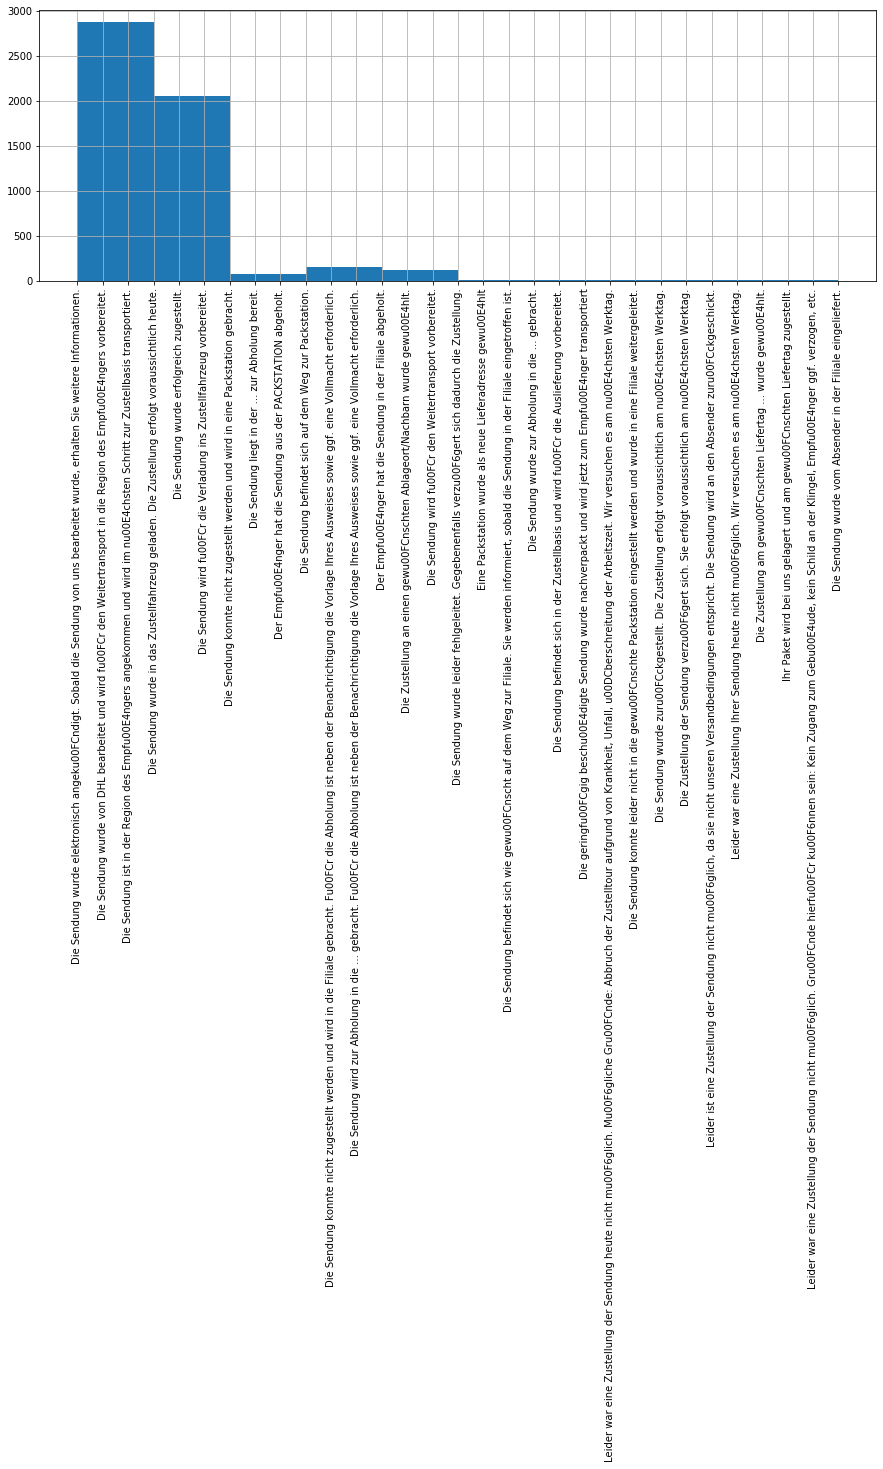

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.xticks(rotation='vertical')
df["status"].hist(figsize=(15,5))

We introduces two new states to status_next: SuccessDelivery, FailedDelivery

### Distribution of the locations

In [34]:
len(df["ort"].unique())

129

In [35]:
pd.DataFrame(df["ort"].value_counts()).head(10)

,ort
Unbekannt,3175
Hamburg,927
Bremen,84
Bremen GVZ,57
Ku00F6ln,56
Krefeld,50
Hagen,50
Dorsten,43
Neumu00FCnster,42
Ku00F6ngen,40


In [36]:
pd.DataFrame(df["ort"].value_counts()).tail(10)

,ort
Frankfurt am Main,1
Mu00FCnster MechZB,1
Berlin Josef-Orlopp-Str. MechZB,1
Aschheim MechZB,1
Wu00FCrzburg,1
Voerde,1
Heidelberg-Leimen MechZB,1
Karlsruhe MechZB,1
Schmelz,1
Lemfu00F6rde,1


Notice: One idea here could be to merge some locations. 

### Remove unused columns

In [37]:
df.drop(columns=["crawltime", "url"], inplace=True)

In [38]:
df.head()

,shipment_number,datum,status,ort,is_final_event,status_next,ort_next,datum_next
0,00340434188193325701,2019-10-08 14:42:00+00:00,Die Sendung wurde elektronisch angeku00FCndigt...,Unbekannt,0.0,Die Sendung wurde von DHL bearbeitet und wird ...,Hamburg,2019-10-08 18:19:00
1,00340434188193325701,2019-10-08 18:19:00+00:00,Die Sendung wurde von DHL bearbeitet und wird ...,Hamburg,0.0,Die Sendung ist in der Region des Empfu00E4nge...,Saulheim,2019-10-09 02:44:00
2,00340434188193325701,2019-10-09 02:44:00+00:00,Die Sendung ist in der Region des Empfu00E4nge...,Saulheim,0.0,Die Sendung wurde in das Zustellfahrzeug gelad...,Unbekannt,2019-10-09 07:46:00
3,00340434188193325701,2019-10-09 07:46:00+00:00,Die Sendung wurde in das Zustellfahrzeug gelad...,Unbekannt,0.0,Die Sendung wurde erfolgreich zugestellt.,Unbekannt,2019-10-09 10:35:00
4,00340434188193325701,2019-10-09 10:35:00+00:00,Die Sendung wurde erfolgreich zugestellt.,Unbekannt,1.0,SuccessDelivery,SuccessDelivery,2019-12-04 00:00:00


### Distribution of event times

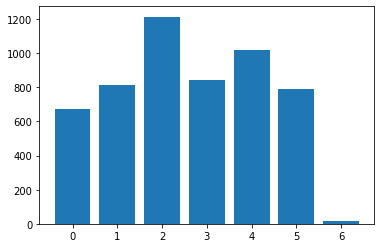

In [39]:
counts = df['datum'].dt.dayofweek.value_counts(sort=False)
plt.bar(counts.index,counts)
plt.show()

We see in the above plot which days of the week have the highest amount of events. Sunday has for example the least amount of events, as expected.

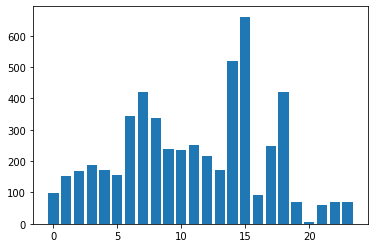

In [40]:
counts = df['datum'].dt.hour.value_counts(sort=False)
plt.bar(counts.index,counts)
plt.show()

In the above plot we see the distribution of the events over 24 hours of a day

### Time diff between events

In [41]:
df['datum'] = pd.to_datetime(df['datum'], utc=True)
df['datum_next'] = pd.to_datetime(df['datum_next'], utc=True)
df["datum_diff"] = df["datum_next"] - df["datum"]

Notice that for is_final_event=1, the datum_diff does not make any sense. Do not use it in the analysis

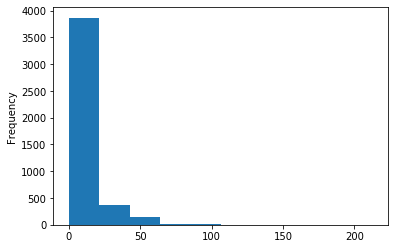

In [42]:
df[df["is_final_event"] == 0]['datum_diff'].astype('timedelta64[h]').plot.hist()

We observe two interesting things here. There are events with zero time diff and there are events with very big time diffs.

### Events with very small time diffs

In [43]:
df[(df["is_final_event"] == 0.0) & (df['datum_diff'].astype('timedelta64[s]') == 0)] 

,shipment_number,datum,status,ort,is_final_event,status_next,ort_next,datum_next,datum_diff
4,00340434188193328467,2019-10-24 06:11:00+00:00,Die Sendung wurde in das Zustellfahrzeug gelad...,Unbekannt,0.0,Die Sendung befindet sich auf dem Weg zur Pack...,Unbekannt,2019-10-24 06:11:00+00:00,0 days
8,00340434188193327675,2019-10-11 08:16:00+00:00,Die Sendung wurde in das Zustellfahrzeug gelad...,Unbekannt,0.0,Die Sendung befindet sich auf dem Weg zur Pack...,Unbekannt,2019-10-11 08:16:00+00:00,0 days
3,00340434188193332709,2019-11-23 09:26:00+00:00,Die Sendung wurde in das Zustellfahrzeug gelad...,Unbekannt,0.0,Die Sendung befindet sich wie gewu00FCnscht au...,Unbekannt,2019-11-23 09:26:00+00:00,0 days
3,00340434188193334130,2019-11-26 11:16:00+00:00,Die Sendung wurde in das Zustellfahrzeug gelad...,Unbekannt,0.0,Die Sendung befindet sich auf dem Weg zur Pack...,Unbekannt,2019-11-26 11:16:00+00:00,0 days
3,00340434188193326272,2019-10-11 07:41:00+00:00,Die Sendung wurde in das Zustellfahrzeug gelad...,Unbekannt,0.0,Die Sendung befindet sich auf dem Weg zur Pack...,Unbekannt,2019-10-11 07:41:00+00:00,0 days
3,00340434188193334062,2019-11-26 08:27:00+00:00,Die Sendung wurde in das Zustellfahrzeug gelad...,Unbekannt,0.0,Die Sendung befindet sich auf dem Weg zur Pack...,Unbekannt,2019-11-26 08:27:00+00:00,0 days
3,00340434188193331962,2019-11-14 08:02:00+00:00,Die Sendung wurde in das Zustellfahrzeug gelad...,Unbekannt,0.0,Die Sendung befindet sich auf dem Weg zur Pack...,Unbekannt,2019-11-14 08:02:00+00:00,0 days
5,00340434188193330200,2019-11-04 08:16:00+00:00,Die Sendung wurde in das Zustellfahrzeug gelad...,Unbekannt,0.0,Die Sendung befindet sich auf dem Weg zur Pack...,Unbekannt,2019-11-04 08:16:00+00:00,0 days
3,00340434188193333744,2019-11-23 06:33:00+00:00,Die Sendung wurde in das Zustellfahrzeug gelad...,Unbekannt,0.0,Die Sendung befindet sich auf dem Weg zur Pack...,Unbekannt,2019-11-23 06:33:00+00:00,0 days
3,00340434188193327101,2019-10-10 09:12:00+00:00,Die Sendung wurde in das Zustellfahrzeug gelad...,Unbekannt,0.0,Die Sendung befindet sich auf dem Weg zur Pack...,Unbekannt,2019-10-10 09:12:00+00:00,0 days


### Events with huge time diffs

In [44]:
df[(df["is_final_event"] == 0.0) & (df['datum_diff'].astype('timedelta64[h]') > 150)] 

,shipment_number,datum,status,ort,is_final_event,status_next,ort_next,datum_next,datum_diff
5,00340434188193328757,2019-10-26 13:48:00+00:00,Die Sendung wird zur Abholung in die ... gebra...,Unbekannt,0.0,Der Empfu00E4nger hat die Sendung in der Filia...,Unbekannt,2019-11-04 10:58:00+00:00,8 days 21:10:00


### Distribution of time diff for various states

In [45]:
df["datum_diff_h"] = df['datum_diff'].astype('timedelta64[h]')

In [46]:
df_temp = df[df["is_final_event"] == 0][["datum_diff_h", "status"]]
df_temp.reset_index()
df_temp.index = range(0,df_temp.shape[0])
df_temp.head()

,datum_diff_h,status
0,3.0,Die Sendung wurde elektronisch angeku00FCndigt...
1,8.0,Die Sendung wurde von DHL bearbeitet und wird ...
2,5.0,Die Sendung ist in der Region des Empfu00E4nge...
3,2.0,Die Sendung wurde in das Zustellfahrzeug gelad...
4,2.0,Die Sendung wurde elektronisch angeku00FCndigt...


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  This is separate from the ipykernel package so we can avoid doing imports until


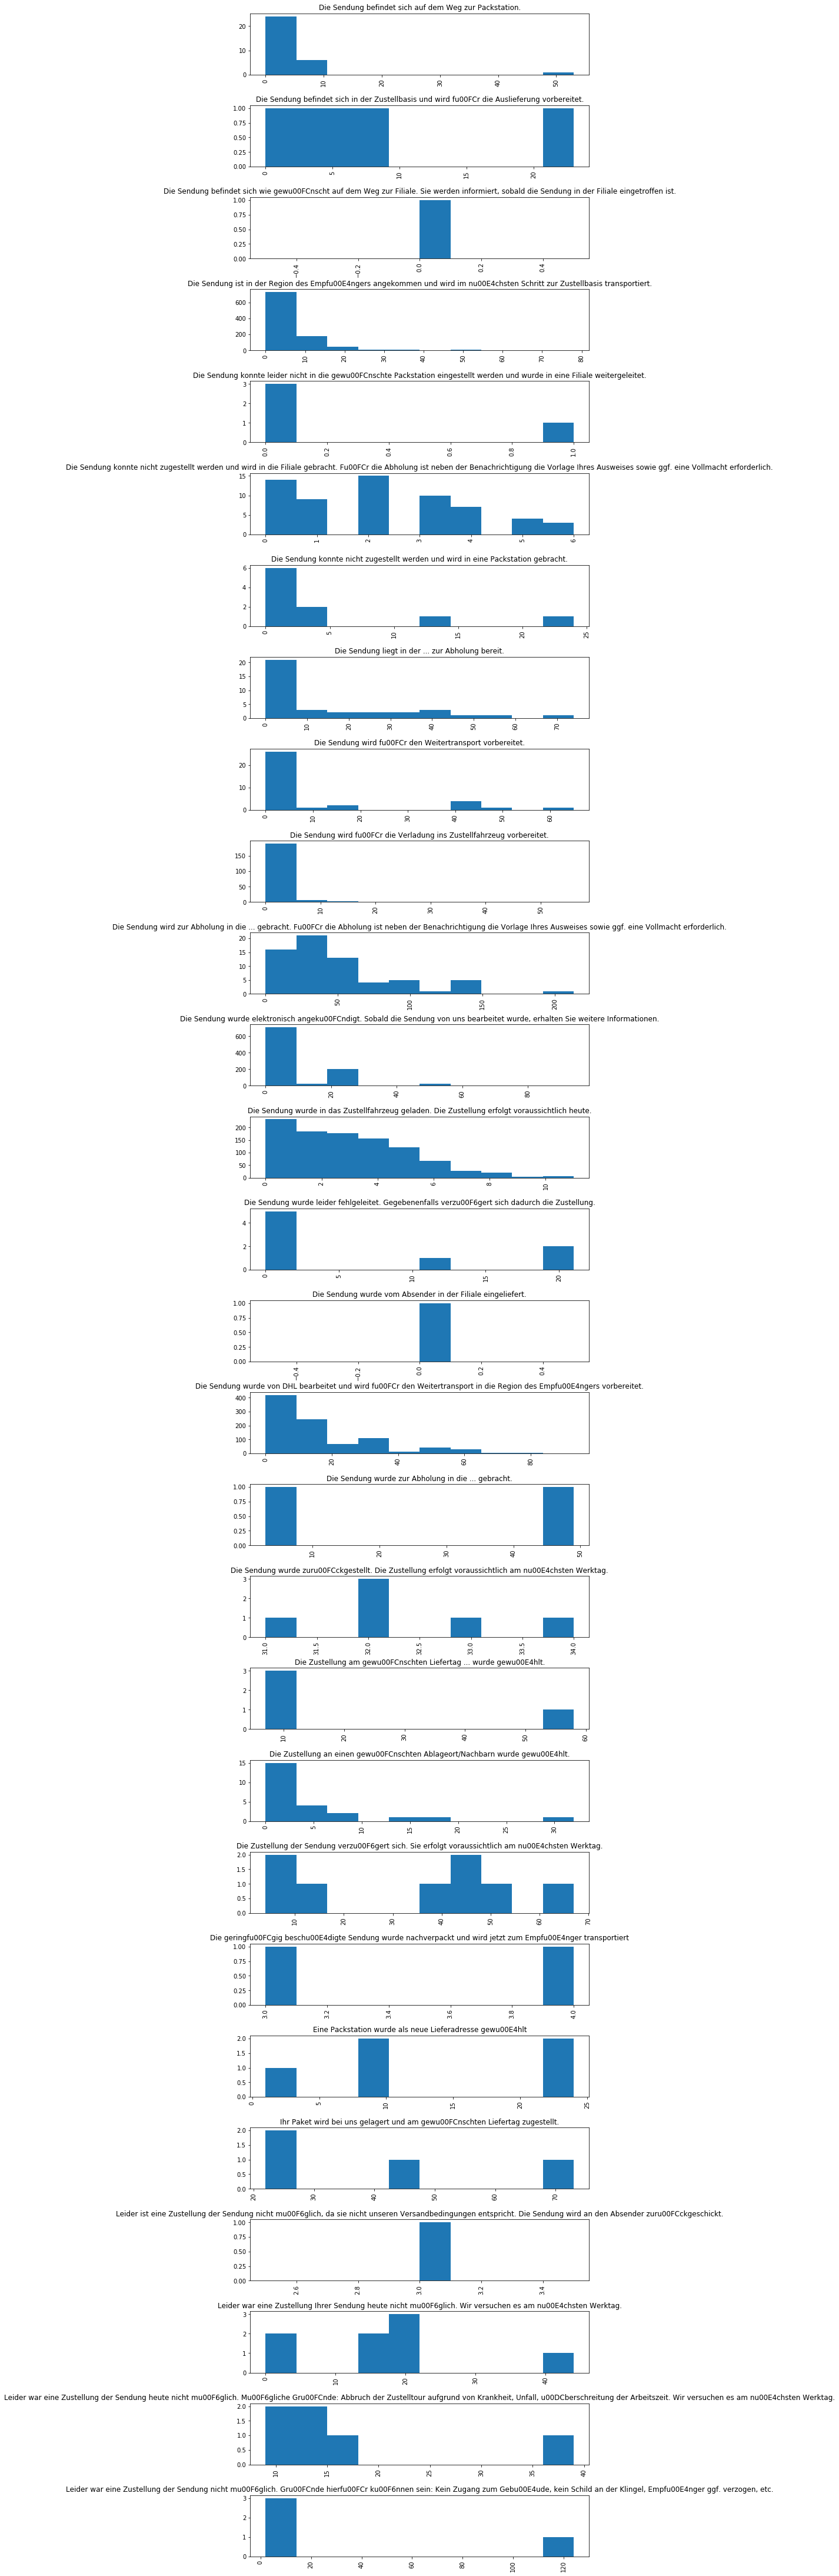

In [47]:
%matplotlib inline
df_temp["datum_diff_h"].hist(by=df_temp['status'], layout=(len(df_temp["status"].unique()), 1), figsize=(10,80))
plt.tight_layout()
df.drop(columns=["datum_diff_h"], inplace=True)

In [48]:
df.head()

,shipment_number,datum,status,ort,is_final_event,status_next,ort_next,datum_next,datum_diff
0,00340434188193325701,2019-10-08 14:42:00+00:00,Die Sendung wurde elektronisch angeku00FCndigt...,Unbekannt,0.0,Die Sendung wurde von DHL bearbeitet und wird ...,Hamburg,2019-10-08 18:19:00+00:00,0 days 03:37:00
1,00340434188193325701,2019-10-08 18:19:00+00:00,Die Sendung wurde von DHL bearbeitet und wird ...,Hamburg,0.0,Die Sendung ist in der Region des Empfu00E4nge...,Saulheim,2019-10-09 02:44:00+00:00,0 days 08:25:00
2,00340434188193325701,2019-10-09 02:44:00+00:00,Die Sendung ist in der Region des Empfu00E4nge...,Saulheim,0.0,Die Sendung wurde in das Zustellfahrzeug gelad...,Unbekannt,2019-10-09 07:46:00+00:00,0 days 05:02:00
3,00340434188193325701,2019-10-09 07:46:00+00:00,Die Sendung wurde in das Zustellfahrzeug gelad...,Unbekannt,0.0,Die Sendung wurde erfolgreich zugestellt.,Unbekannt,2019-10-09 10:35:00+00:00,0 days 02:49:00
4,00340434188193325701,2019-10-09 10:35:00+00:00,Die Sendung wurde erfolgreich zugestellt.,Unbekannt,1.0,SuccessDelivery,SuccessDelivery,2019-12-04 00:00:00+00:00,55 days 13:25:00


### Distribution of time diff for various locations

In [49]:
df["datum_diff_h"] = df['datum_diff'].astype('timedelta64[h]')

In [50]:
df_temp = df[df["is_final_event"] == 0][["datum_diff_h", "status", "ort"]]
df_temp.reset_index()
df_temp.index = range(0,df_temp.shape[0])
df_temp.head()

,datum_diff_h,status,ort
0,3.0,Die Sendung wurde elektronisch angeku00FCndigt...,Unbekannt
1,8.0,Die Sendung wurde von DHL bearbeitet und wird ...,Hamburg
2,5.0,Die Sendung ist in der Region des Empfu00E4nge...,Saulheim
3,2.0,Die Sendung wurde in das Zustellfahrzeug gelad...,Unbekannt
4,2.0,Die Sendung wurde elektronisch angeku00FCndigt...,Unbekannt


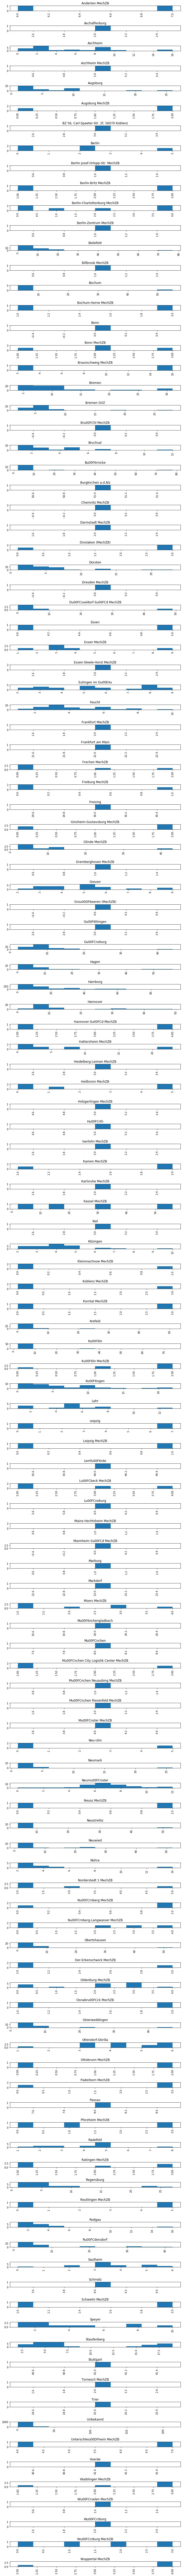

In [51]:
%matplotlib inline
df_temp["datum_diff_h"].hist(by=df_temp['ort'], layout=(len(df_temp["ort"].unique()), 1), figsize=(10,140))
plt.tight_layout()
df.drop(columns=["datum_diff_h"], inplace=True)

### Distribution of time diff for various locations and states

In [52]:
df["datum_diff_h"] = df['datum_diff'].astype('timedelta64[h]')

In [53]:
df_temp = df[df["is_final_event"] == 0][["datum_diff_h", "status", "ort"]]
df_temp.reset_index()
df_temp.index = range(0,df_temp.shape[0])
df_temp.head()

,datum_diff_h,status,ort
0,3.0,Die Sendung wurde elektronisch angeku00FCndigt...,Unbekannt
1,8.0,Die Sendung wurde von DHL bearbeitet und wird ...,Hamburg
2,5.0,Die Sendung ist in der Region des Empfu00E4nge...,Saulheim
3,2.0,Die Sendung wurde in das Zustellfahrzeug gelad...,Unbekannt
4,2.0,Die Sendung wurde elektronisch angeku00FCndigt...,Unbekannt


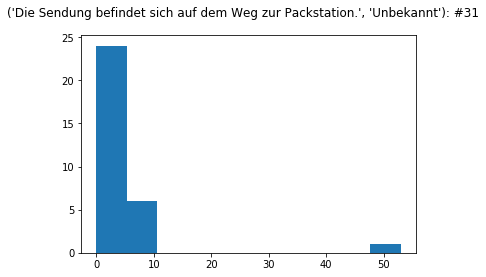

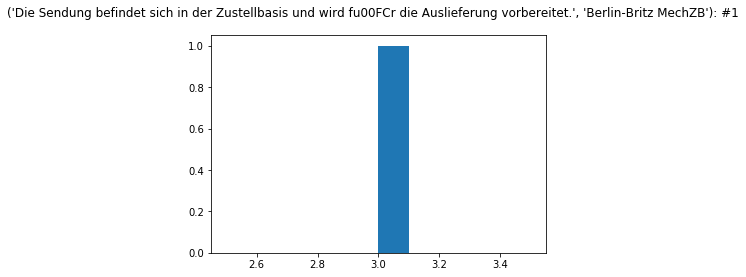

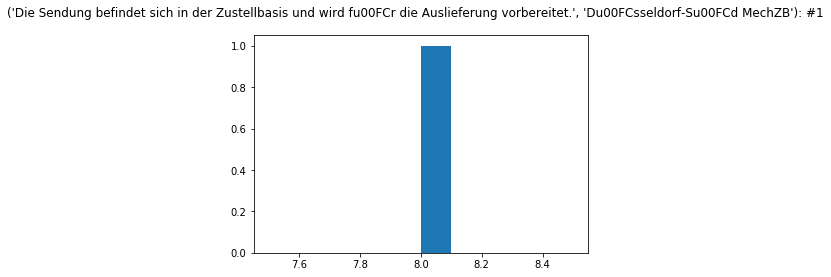

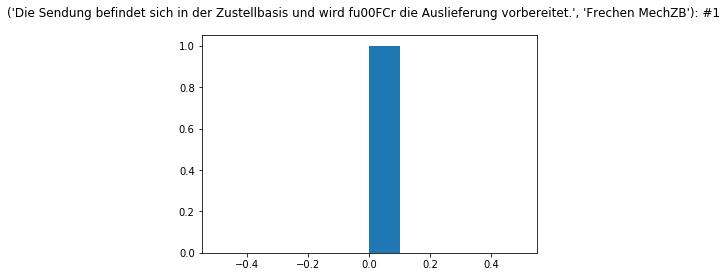

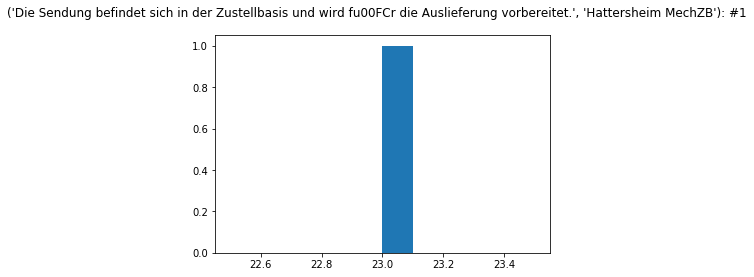

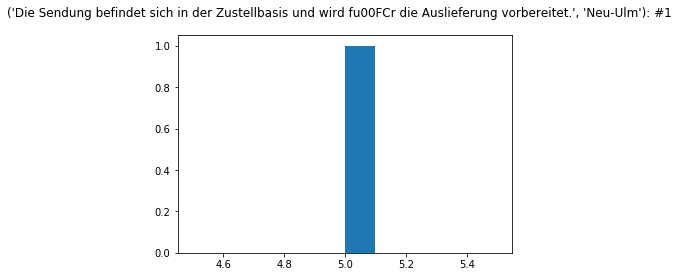

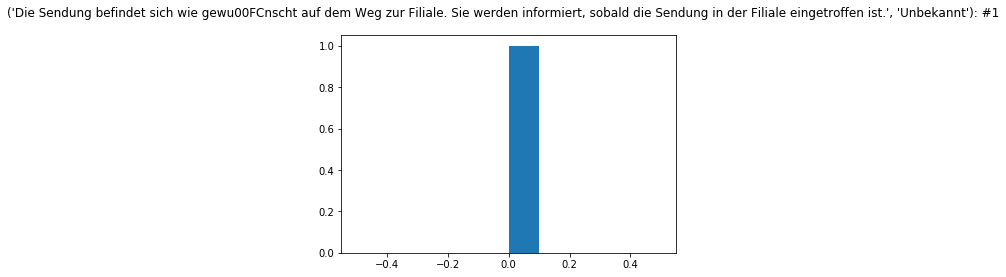

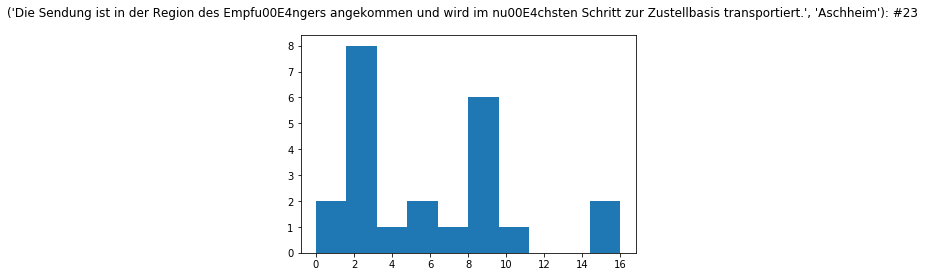

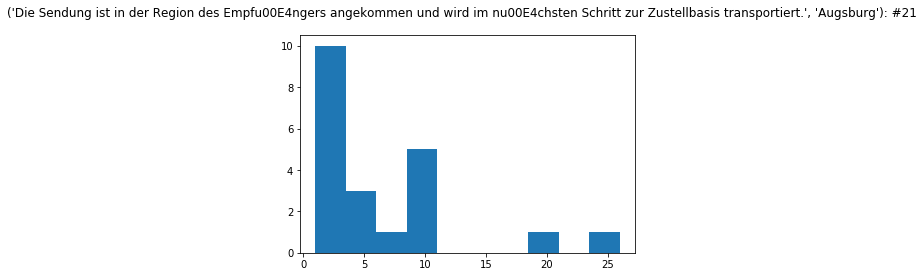

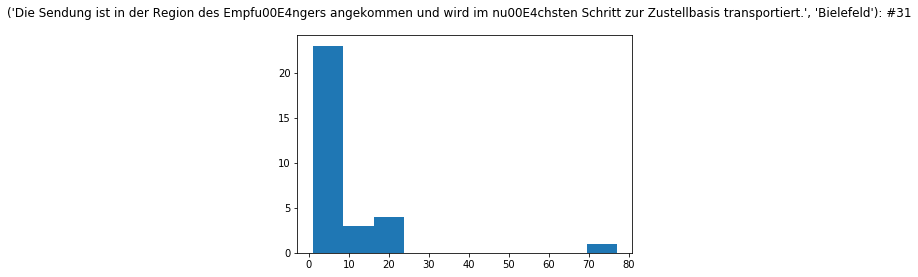

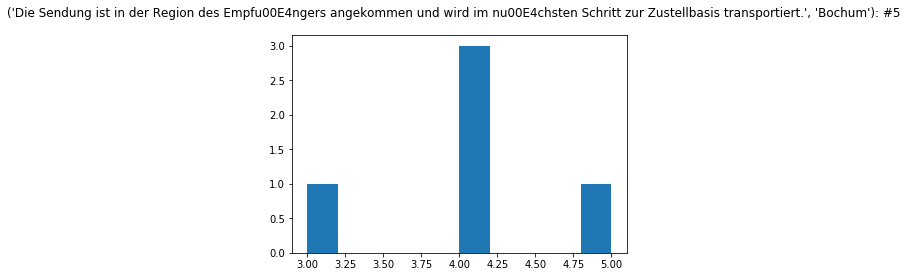

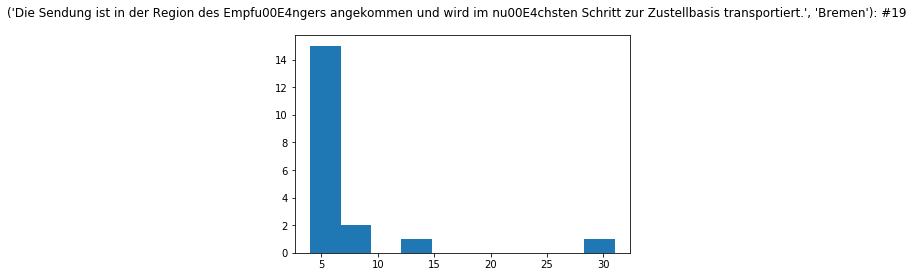

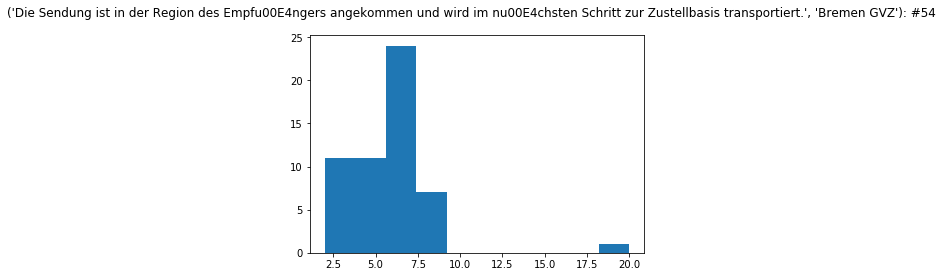

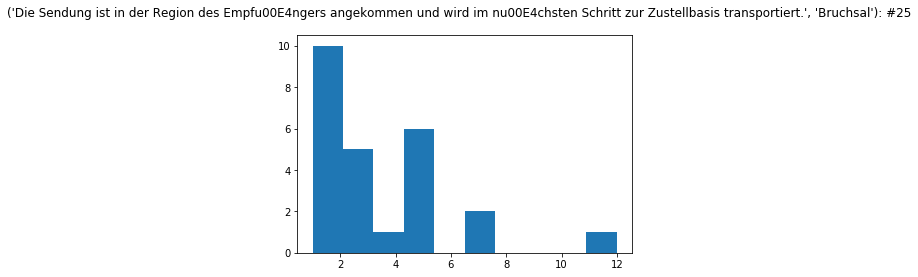

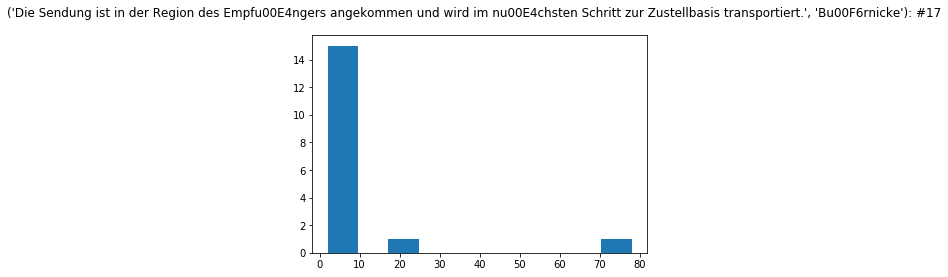

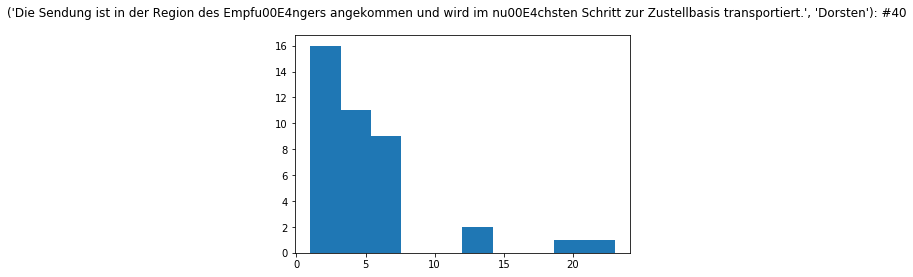

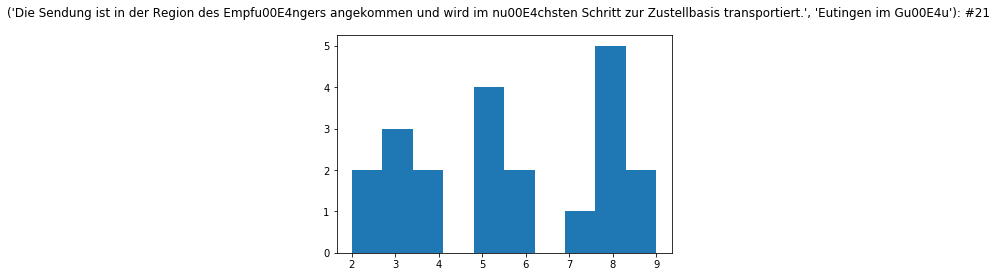

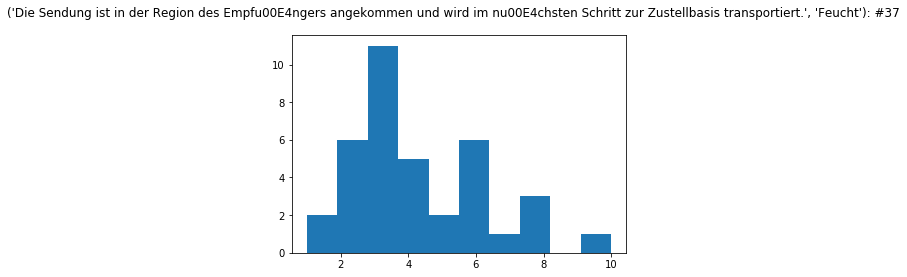

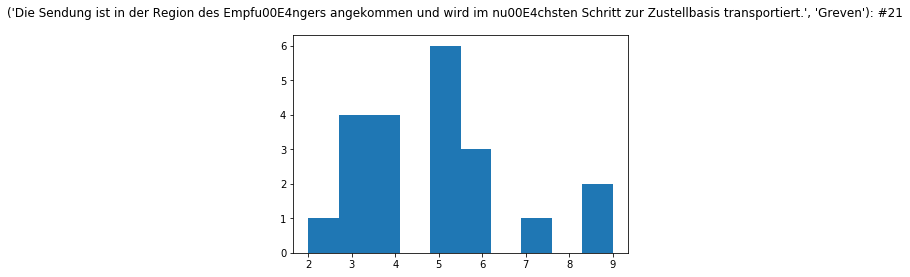

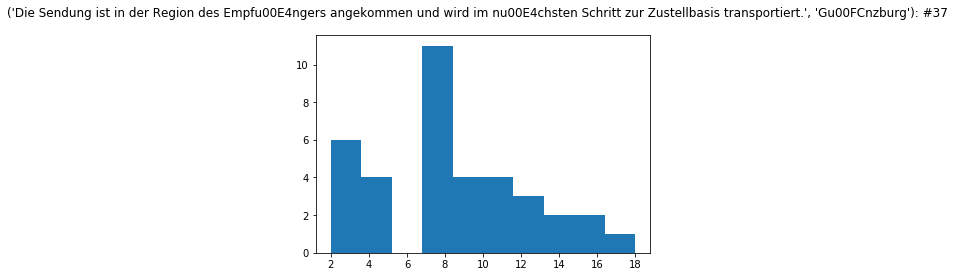

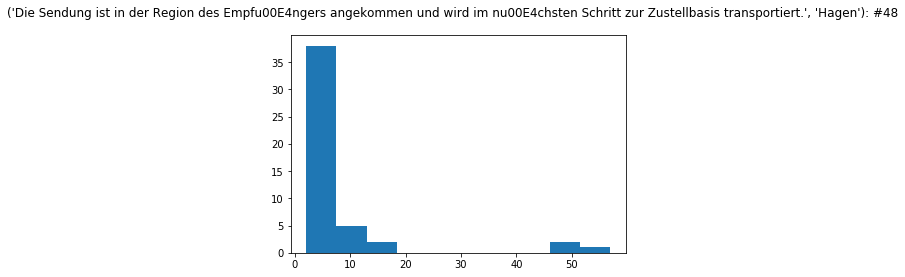

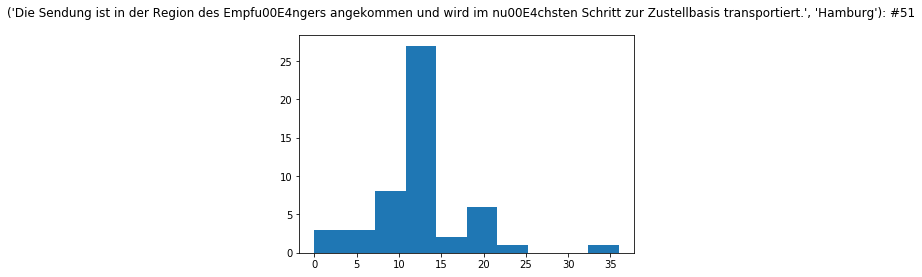

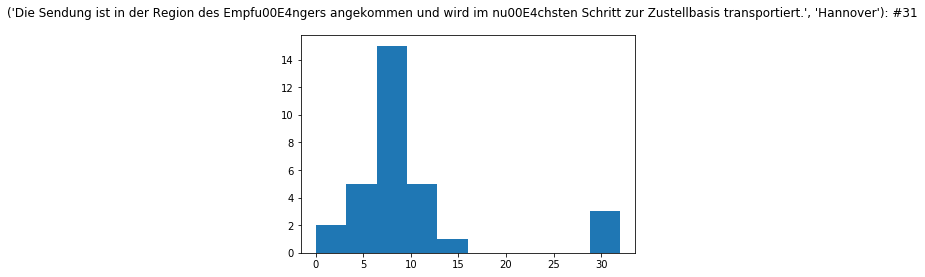

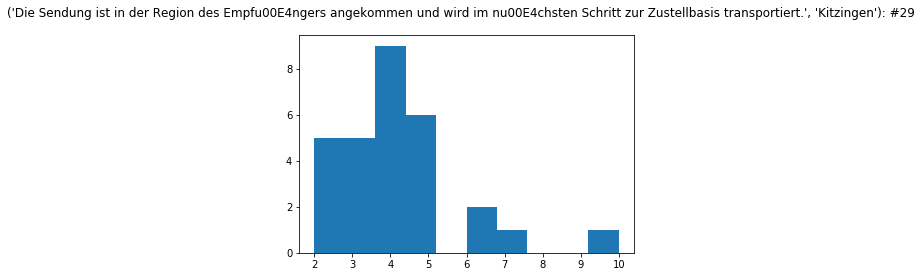

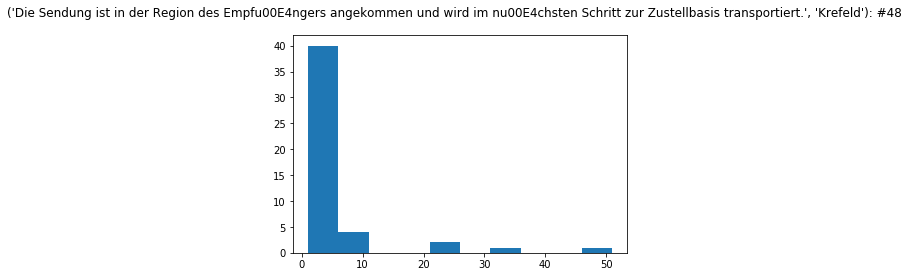

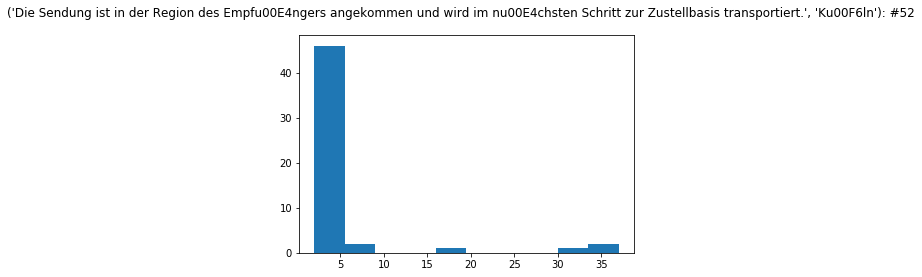

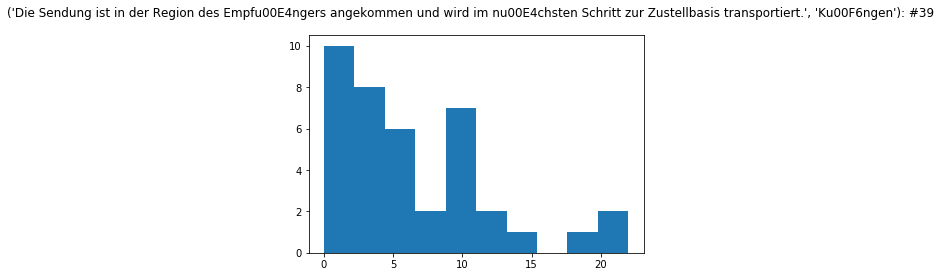

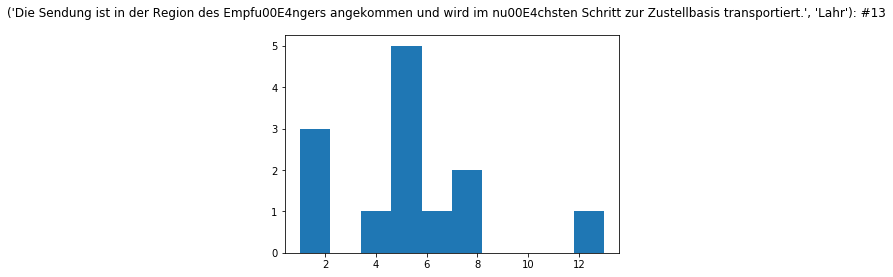

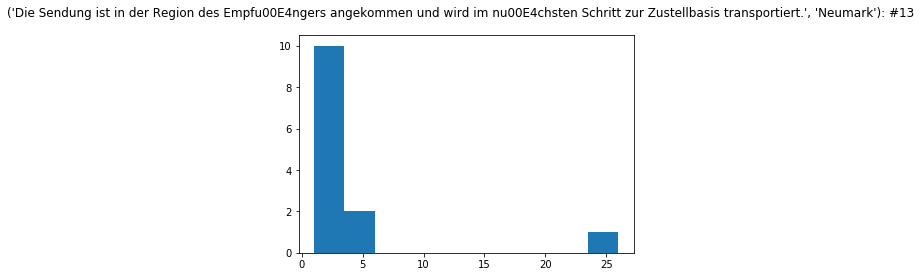

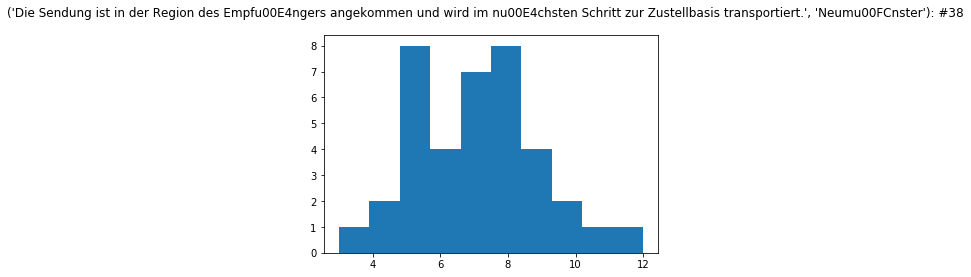

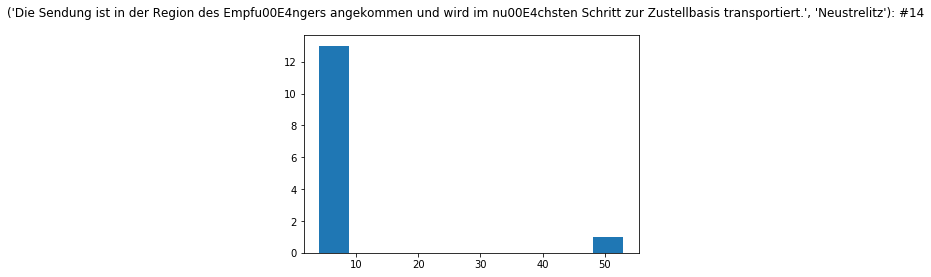

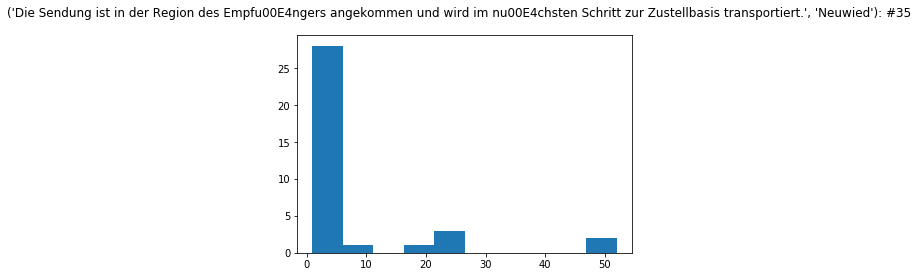

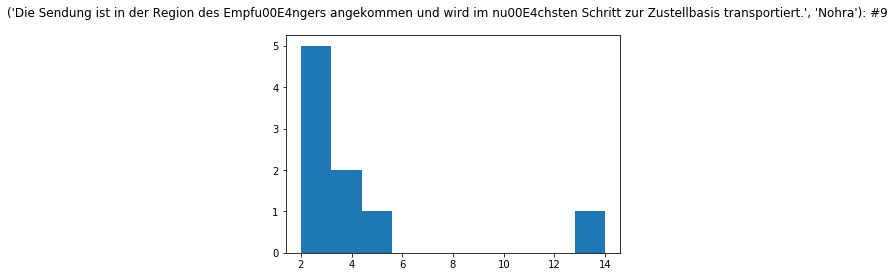

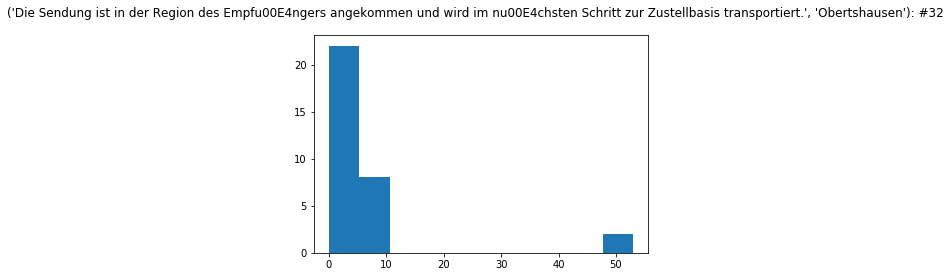

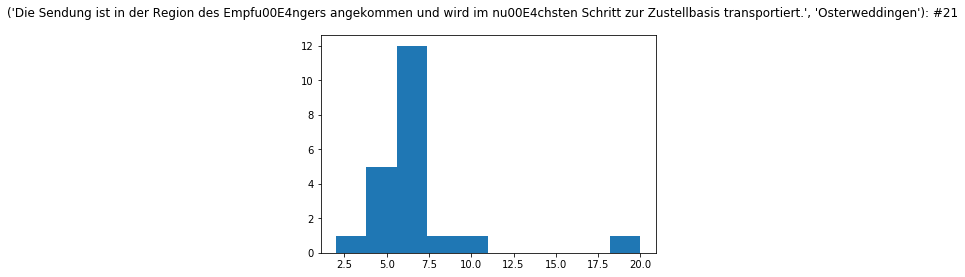

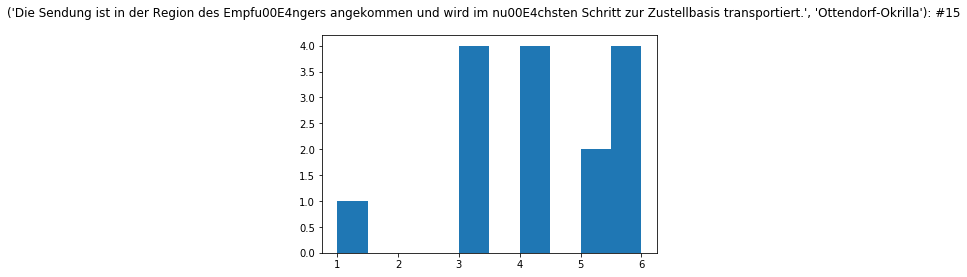

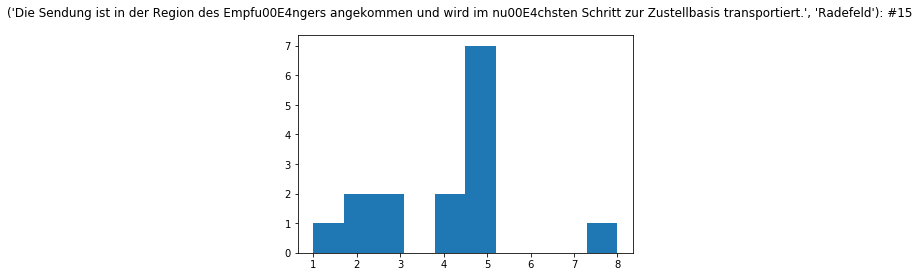

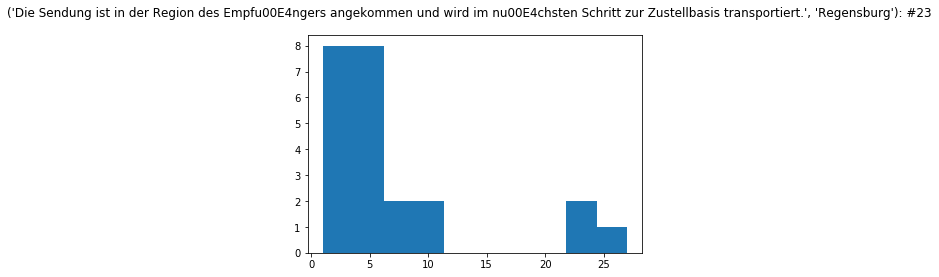

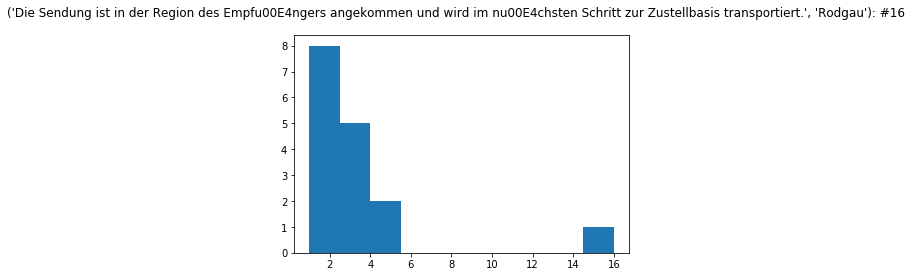

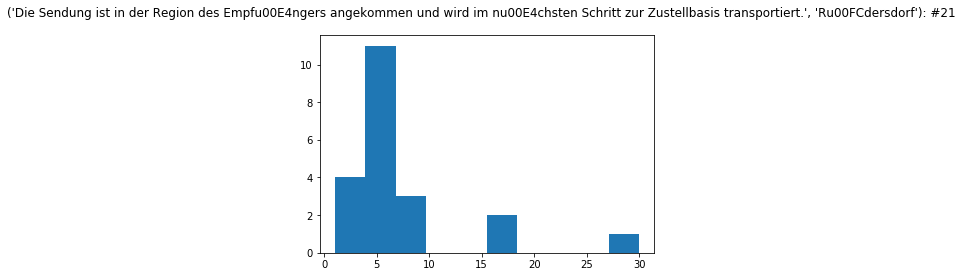

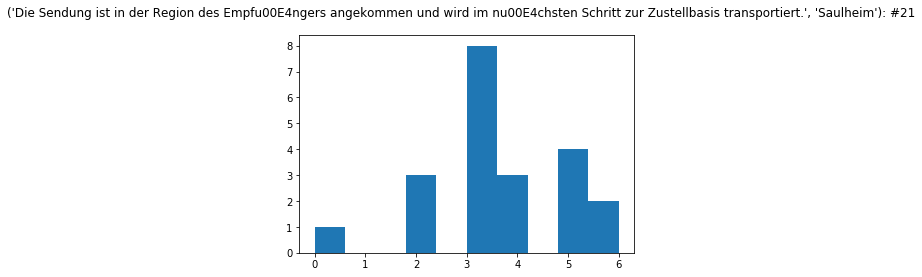

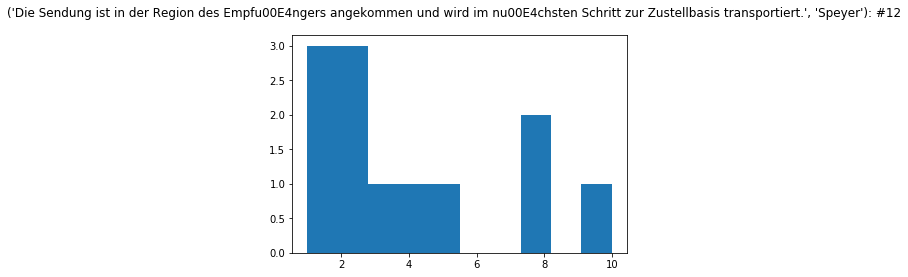

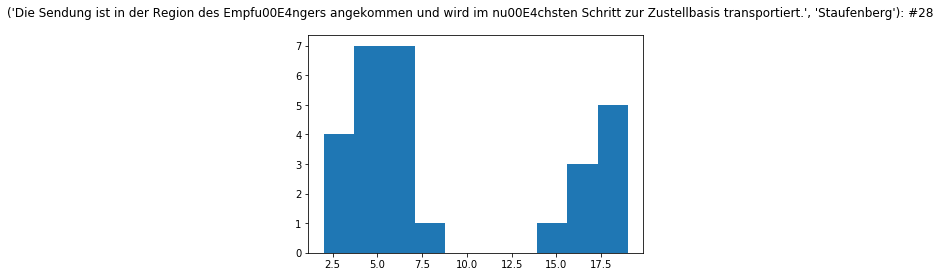

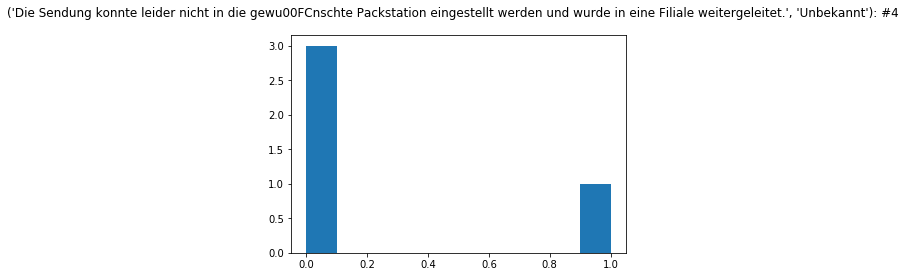

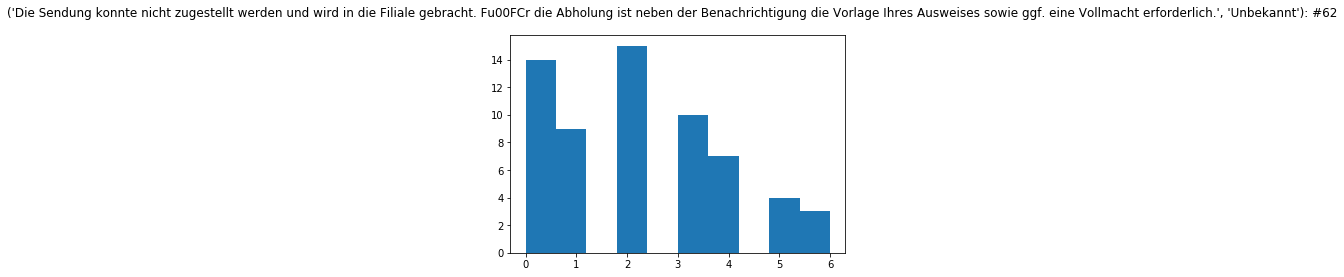

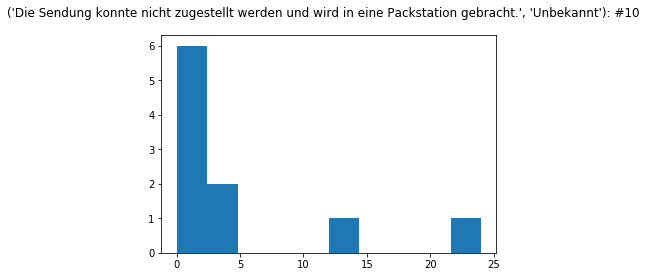

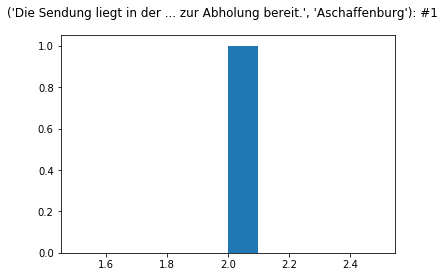

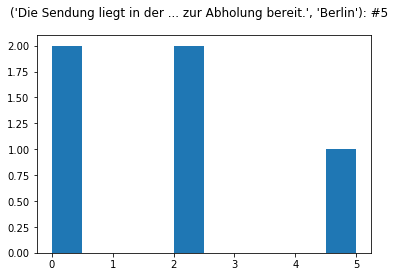

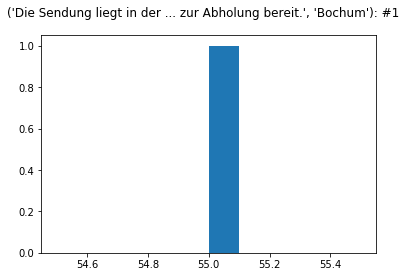

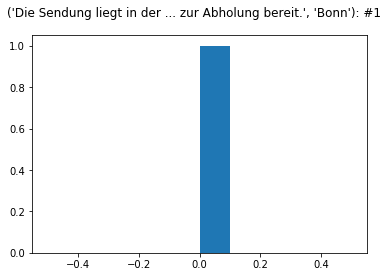

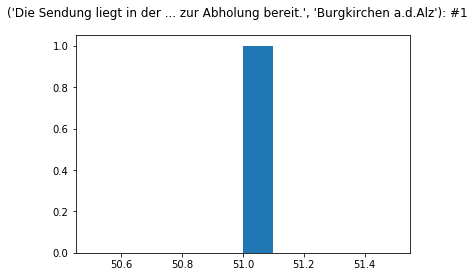

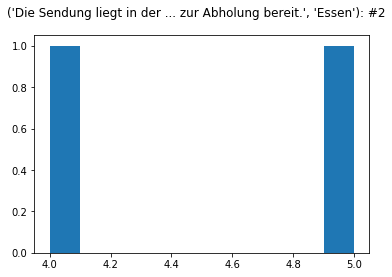

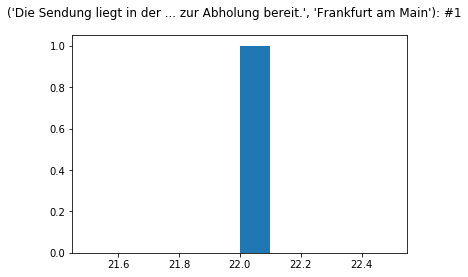

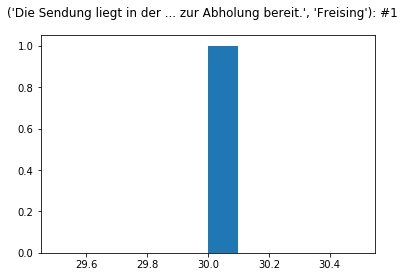

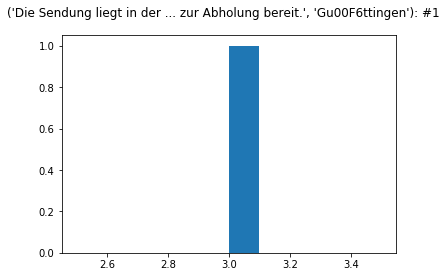

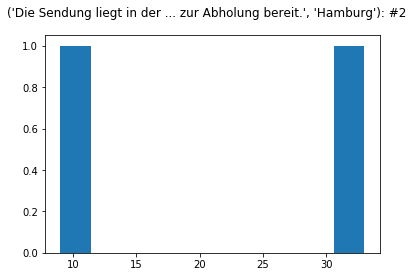

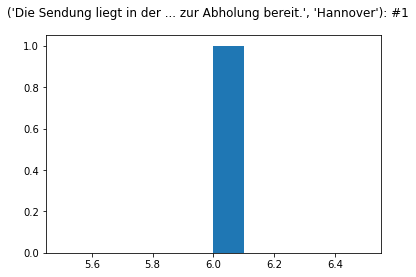

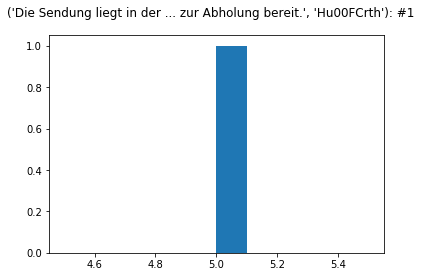

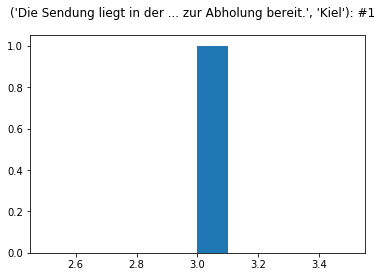

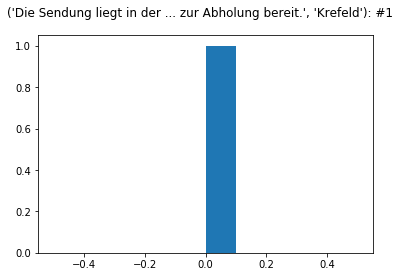

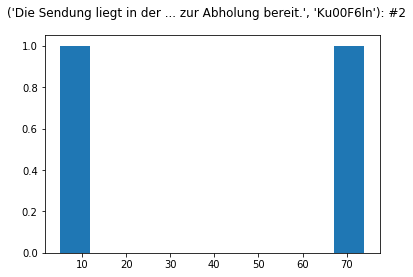

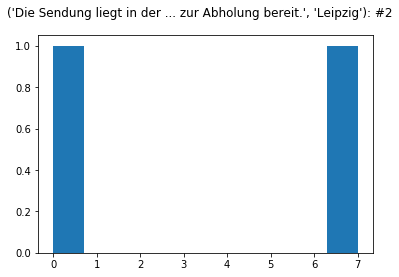

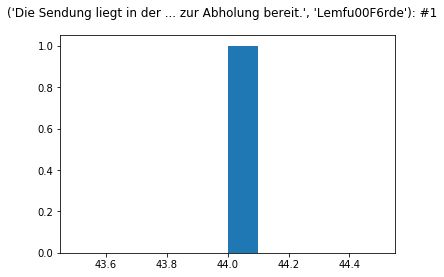

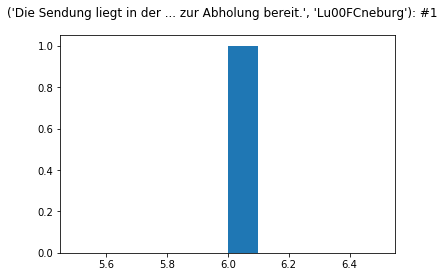

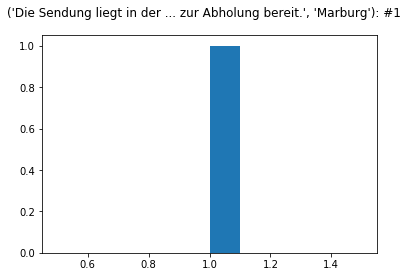

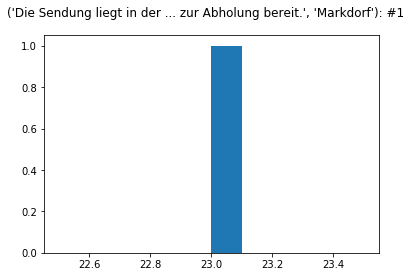

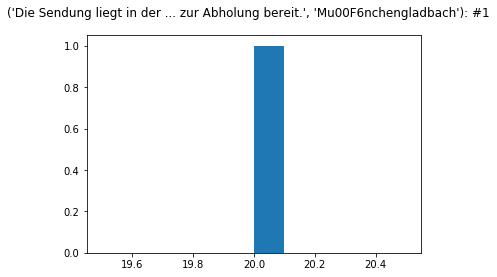

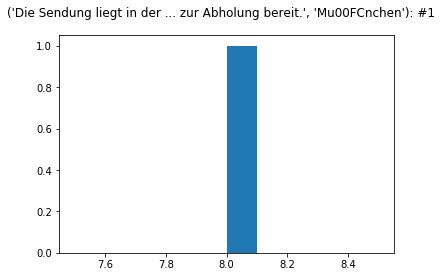

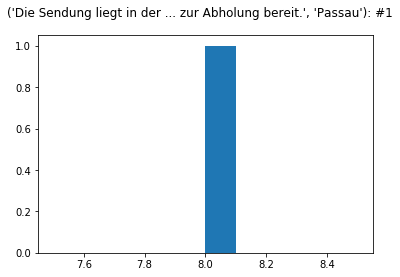

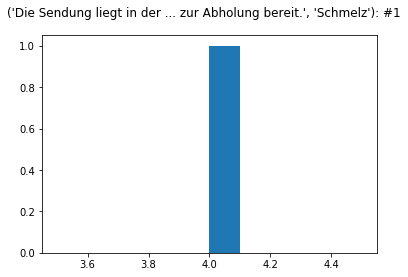

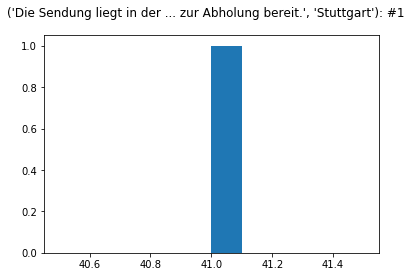

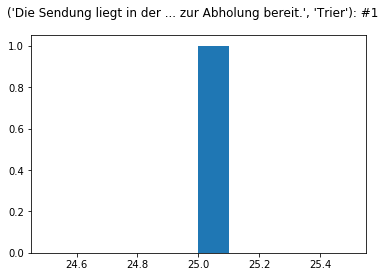

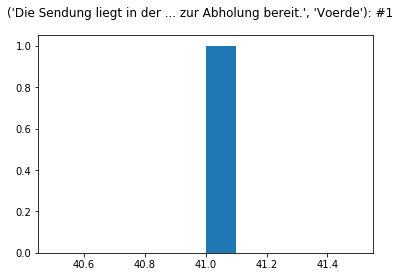

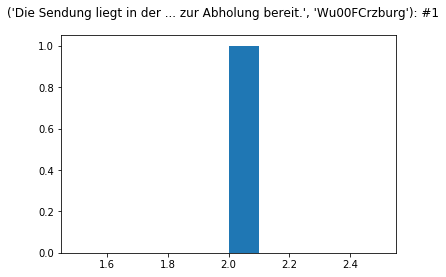

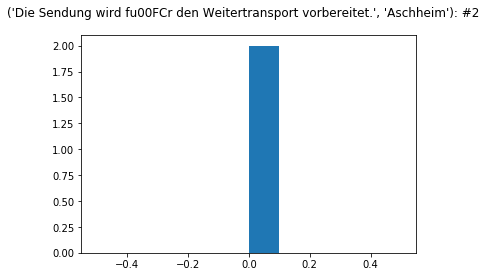

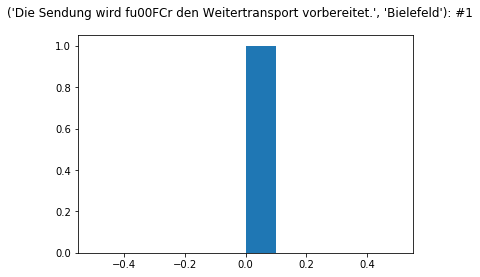

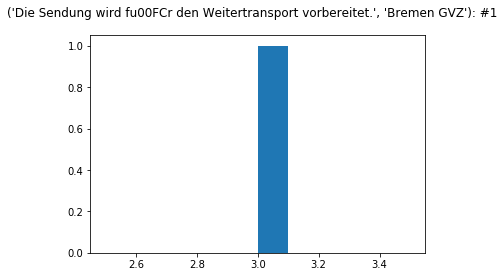

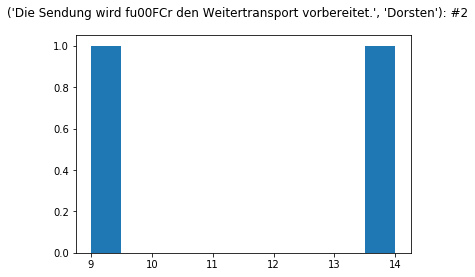

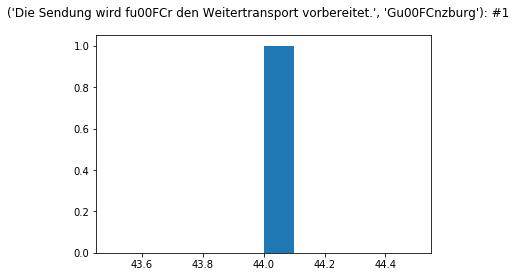

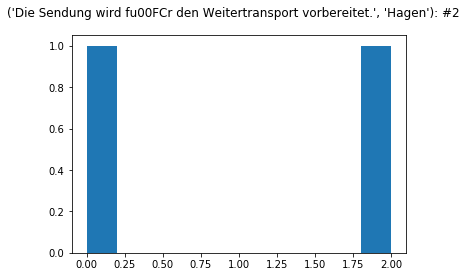

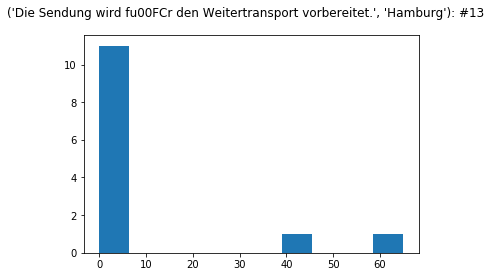

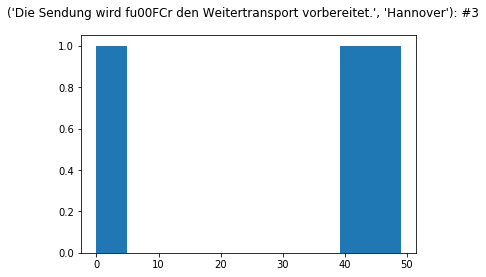

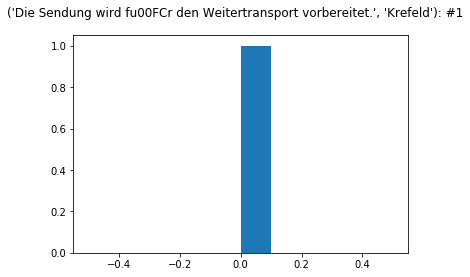

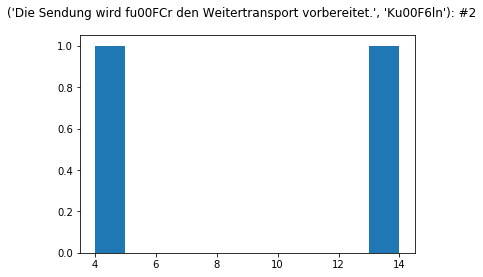

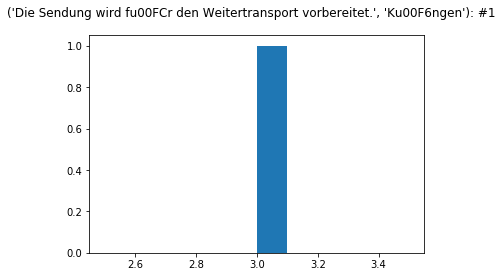

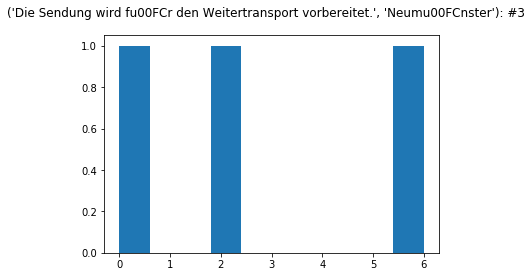

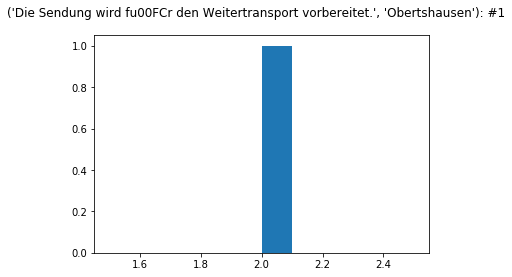

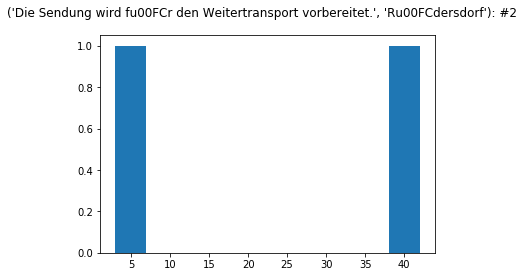

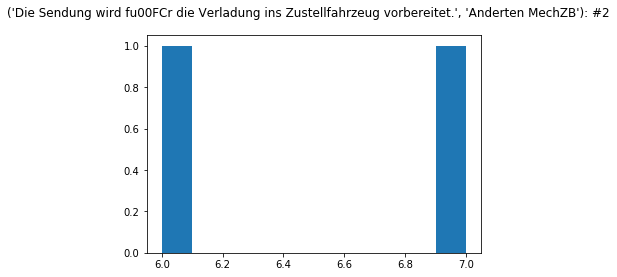

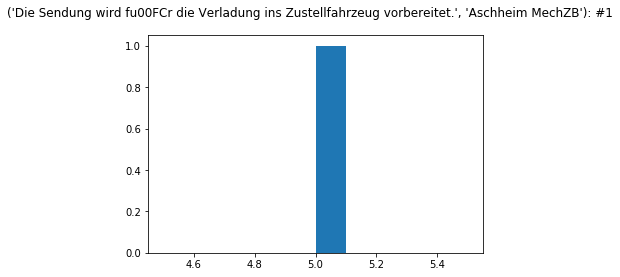

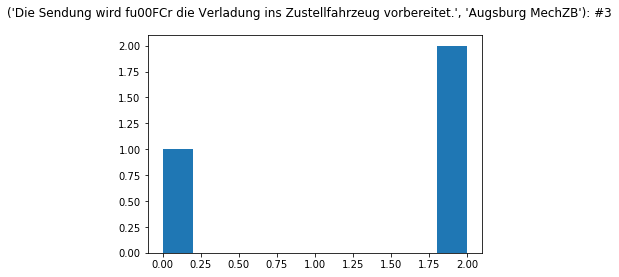

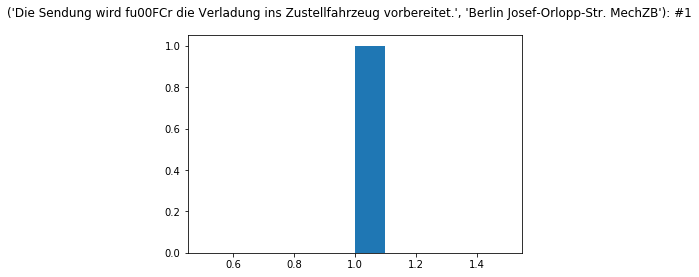

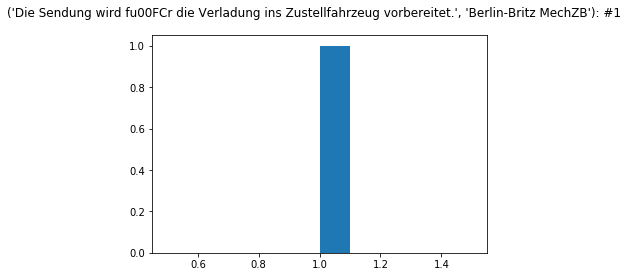

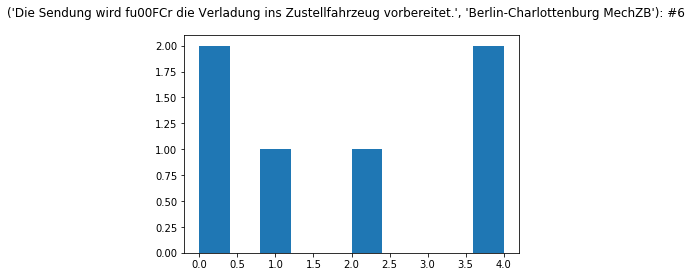

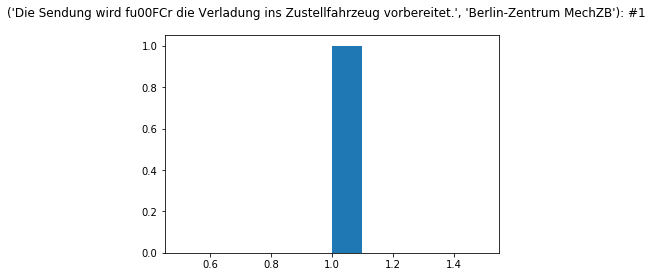

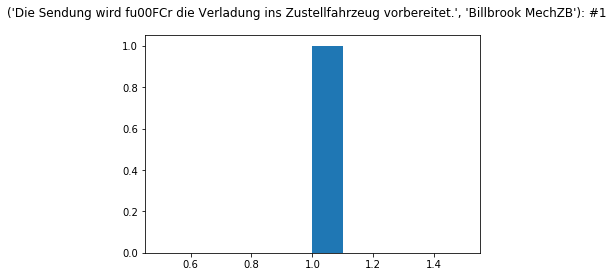

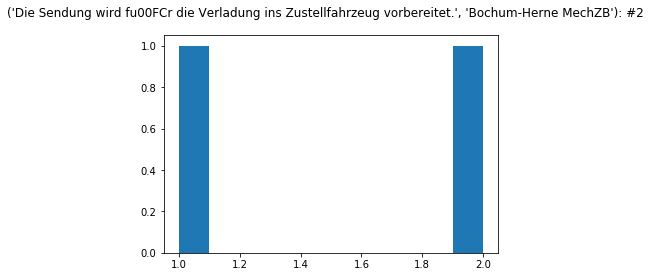

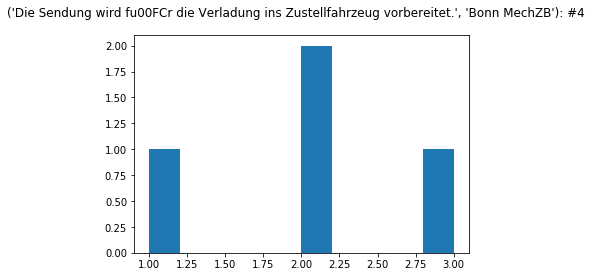

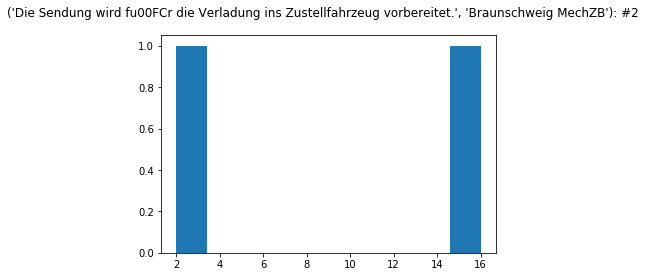

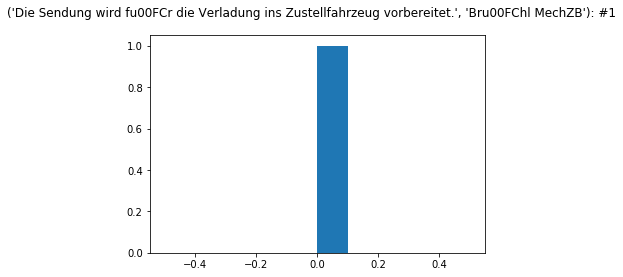

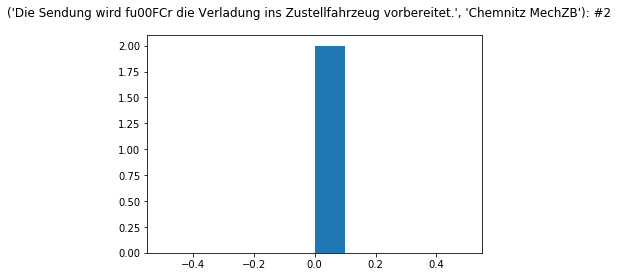

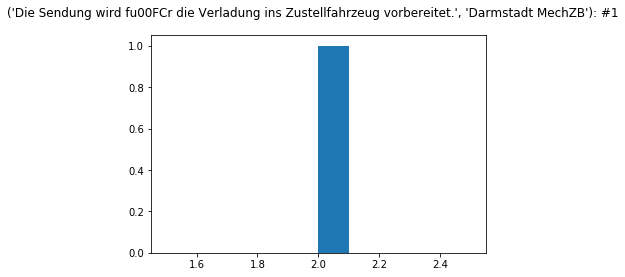

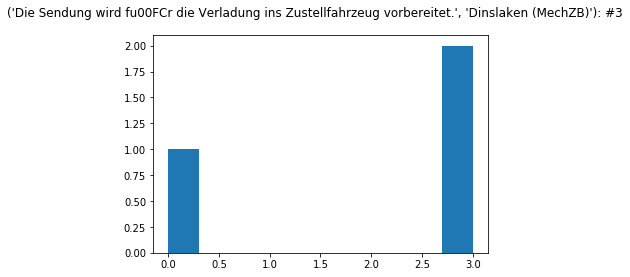

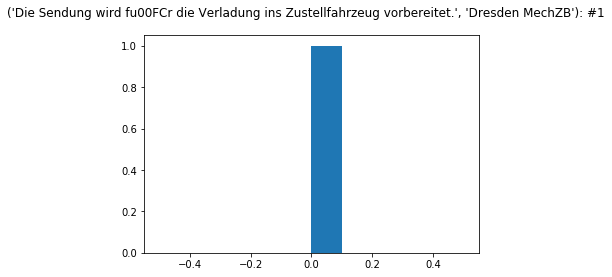

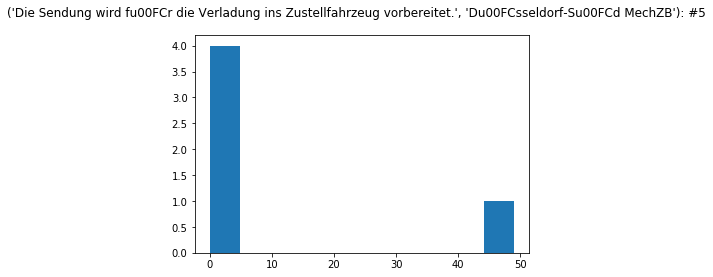

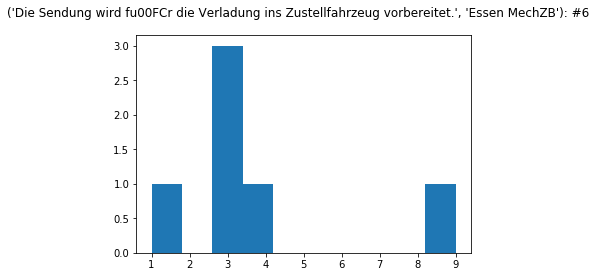

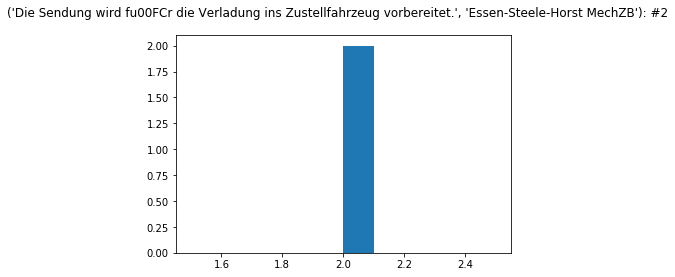

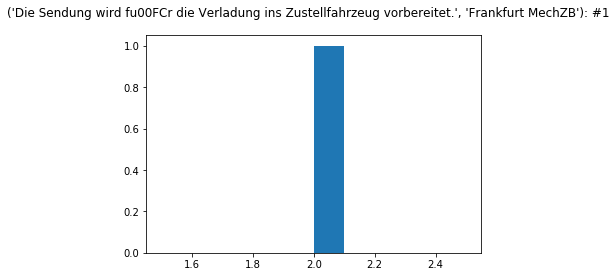

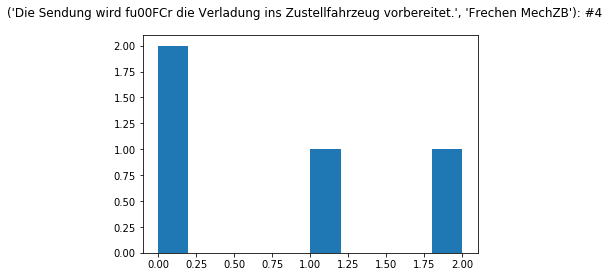

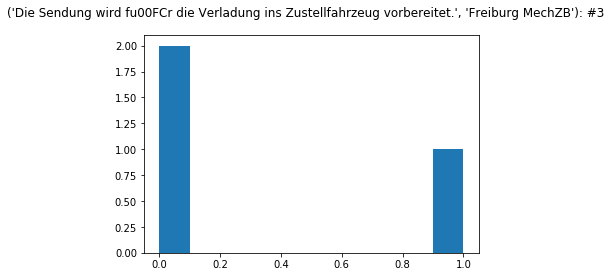

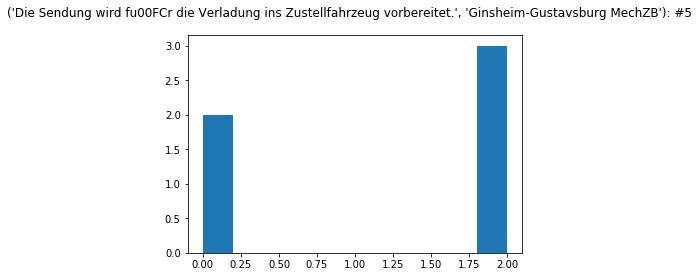

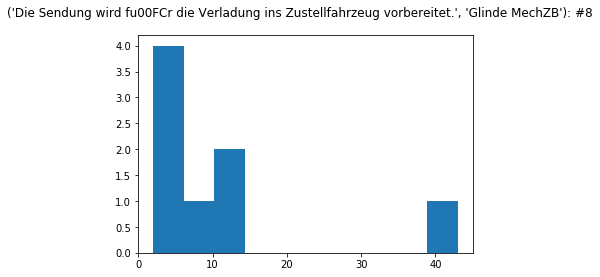

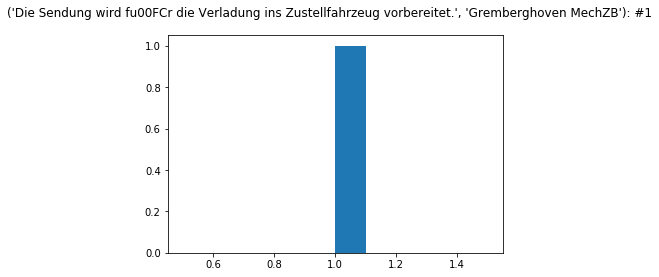

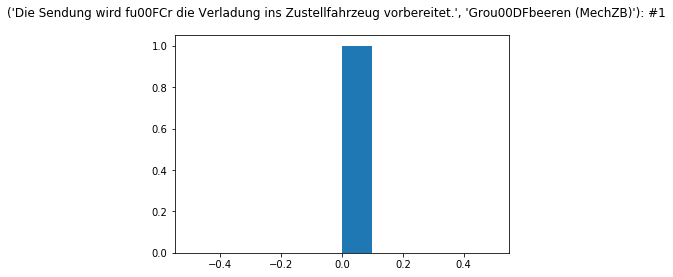

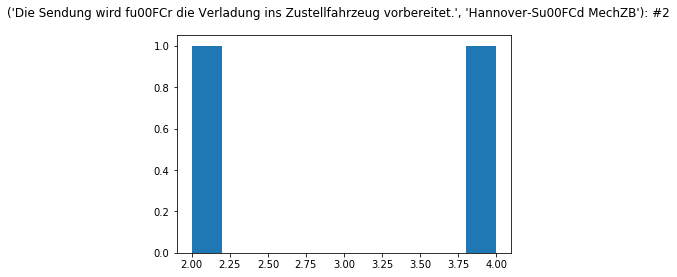

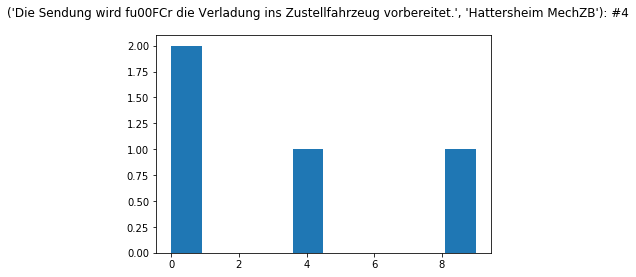

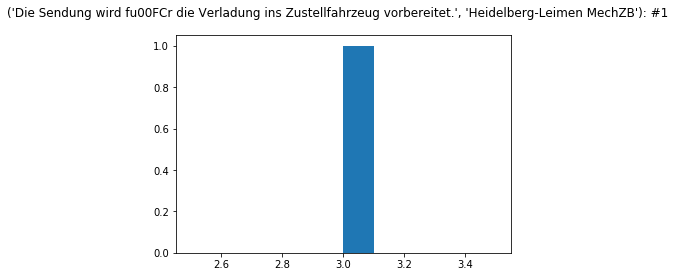

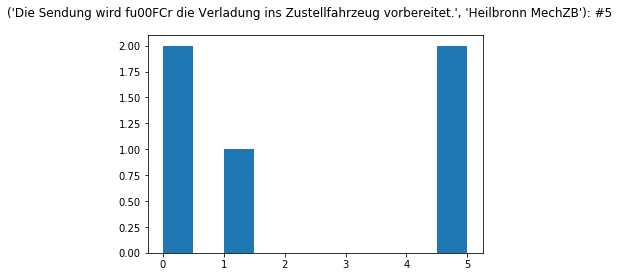

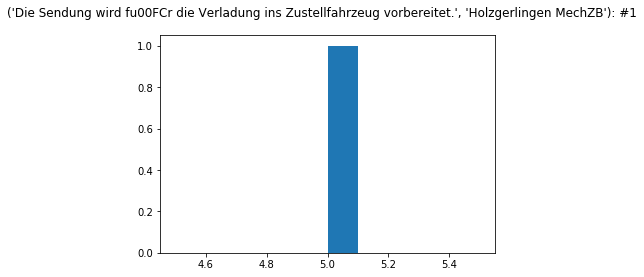

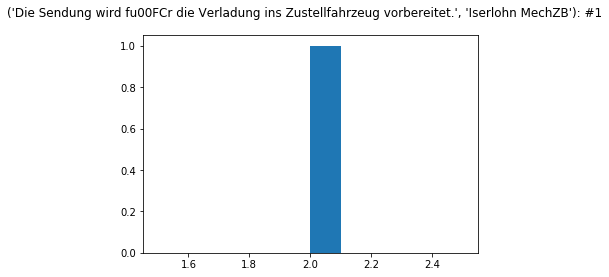

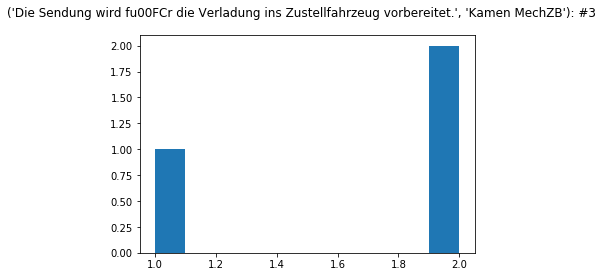

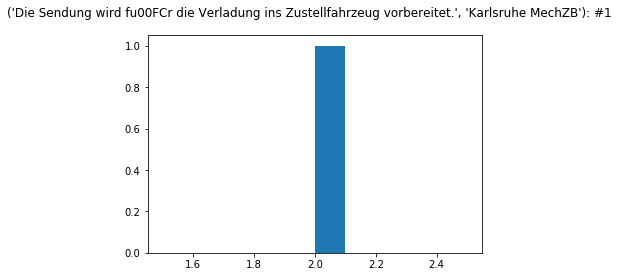

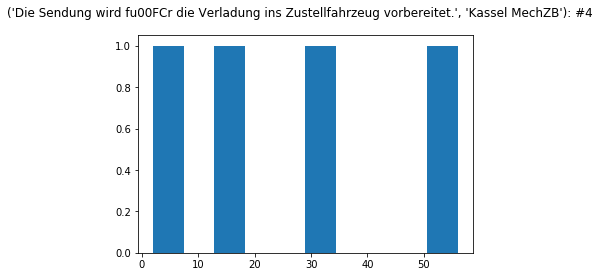

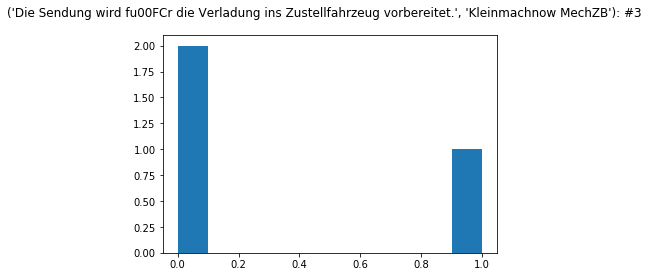

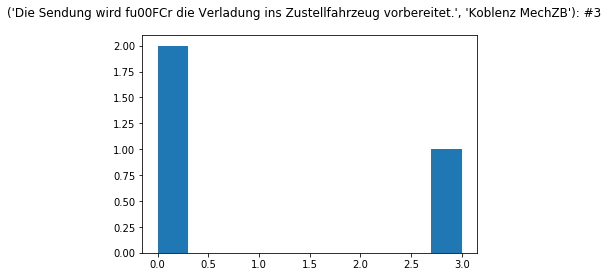

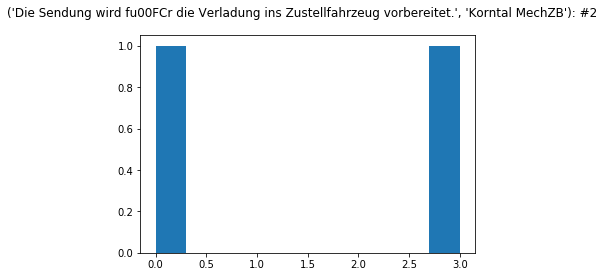

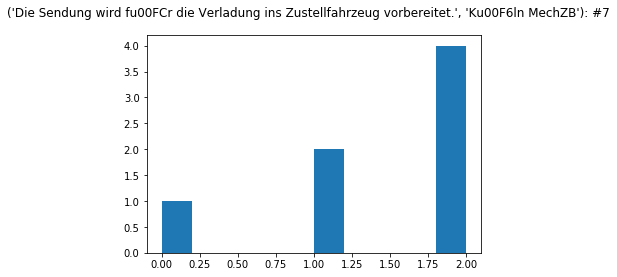

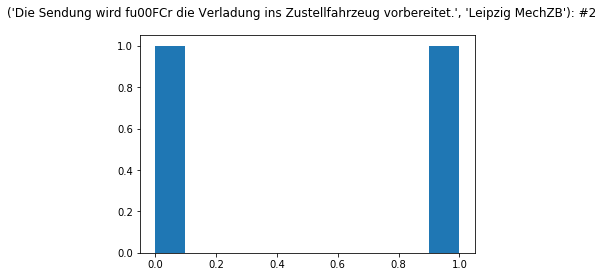

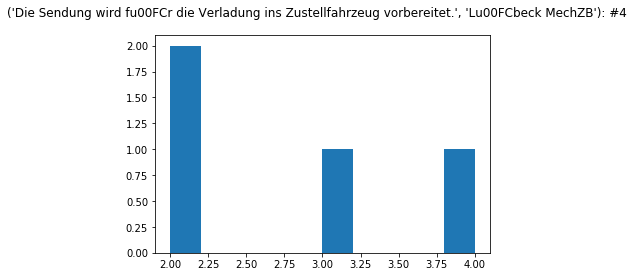

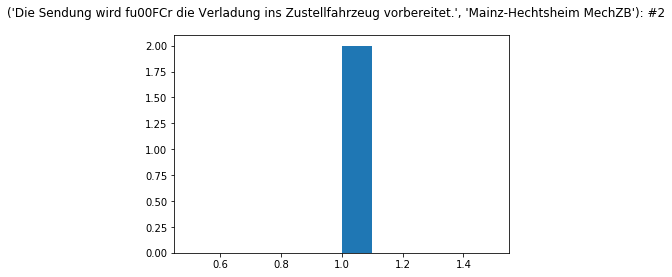

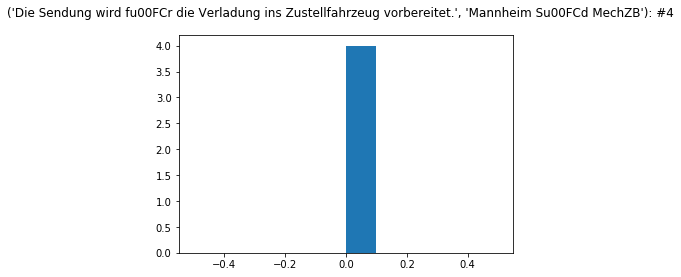

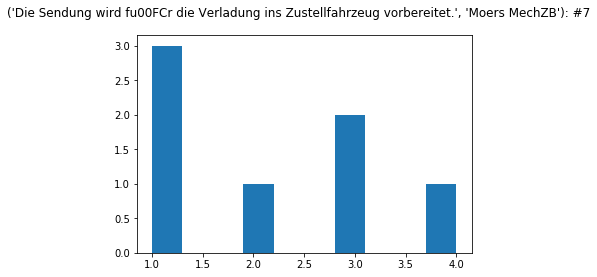

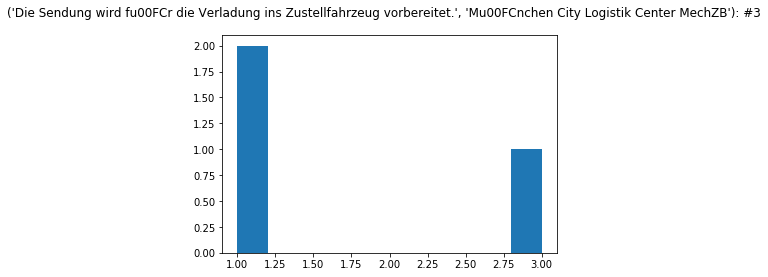

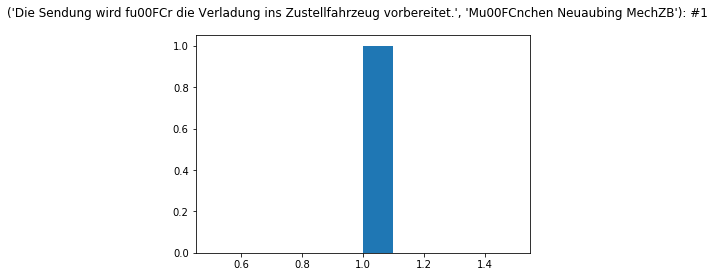

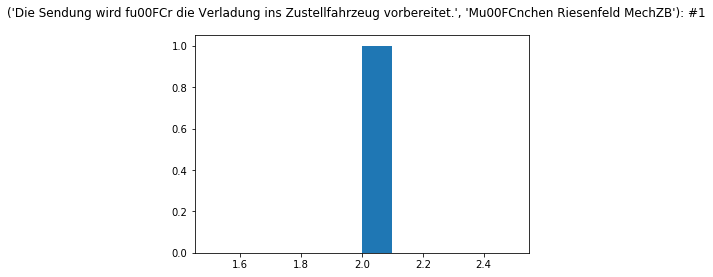

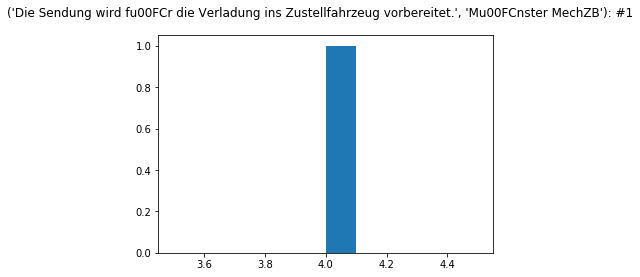

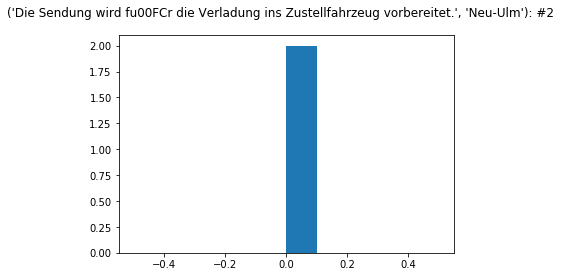

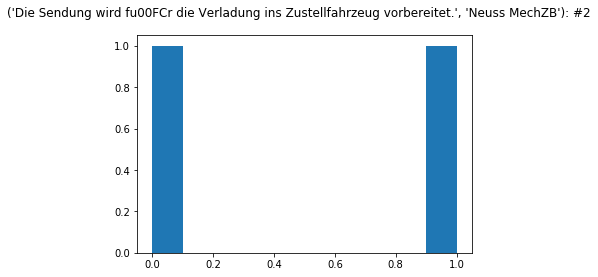

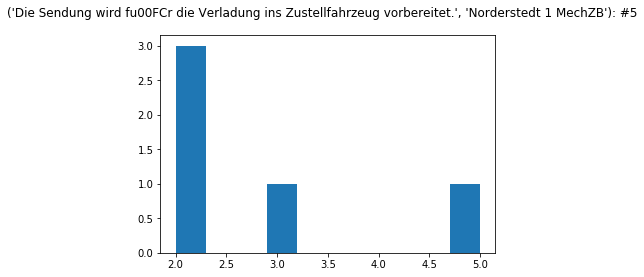

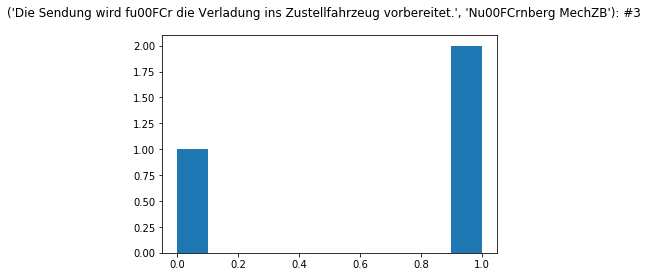

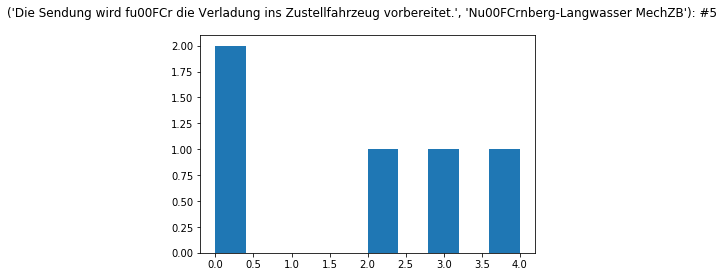

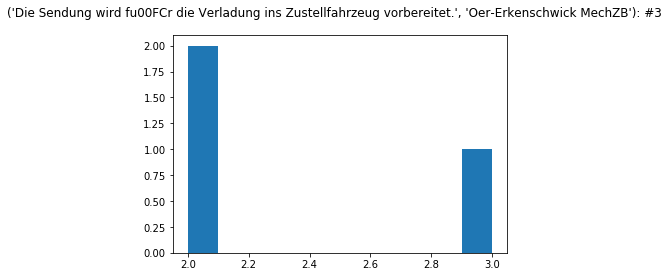

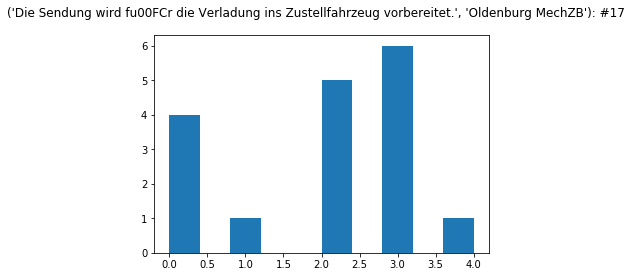

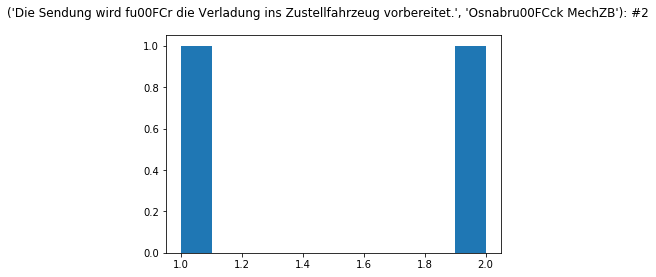

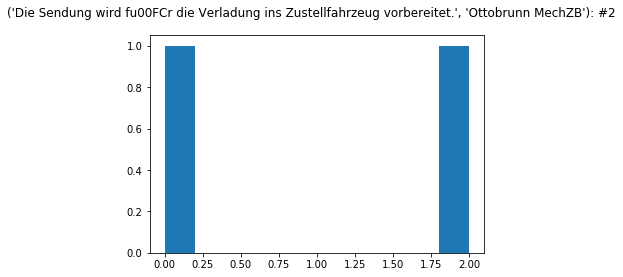

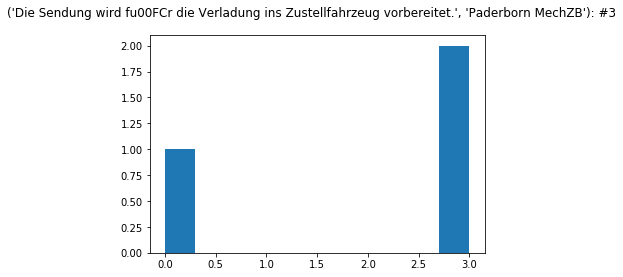

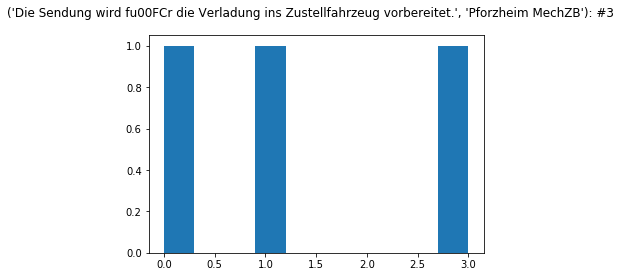

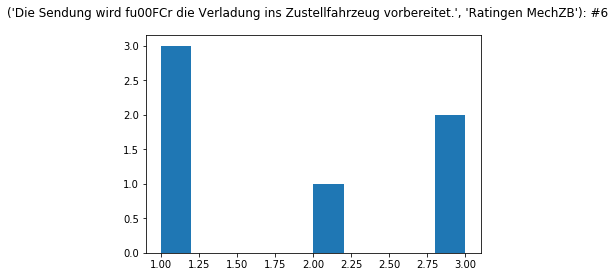

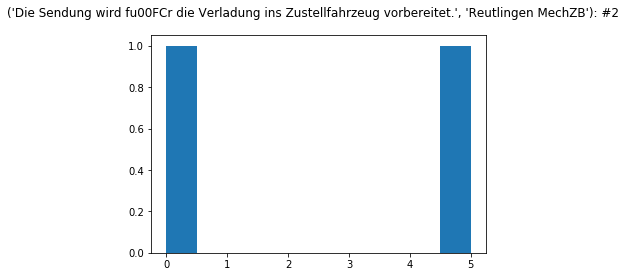

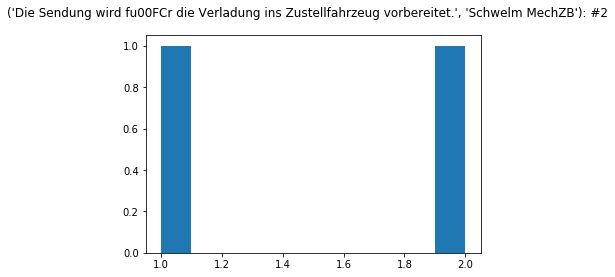

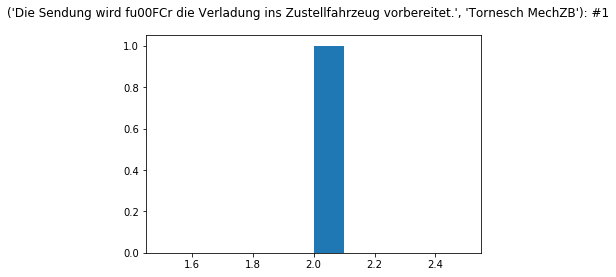

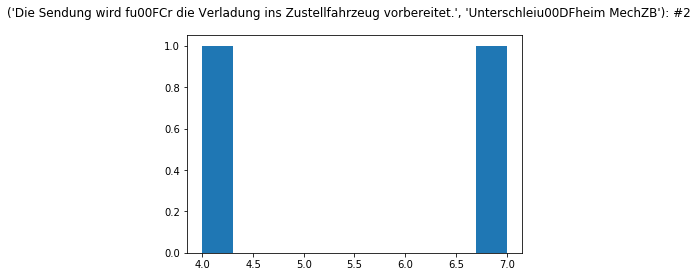

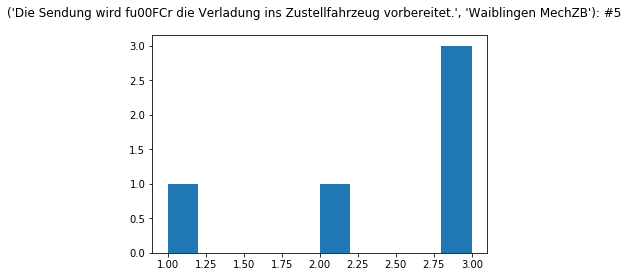

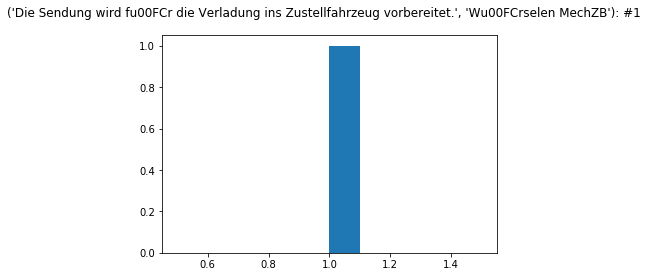

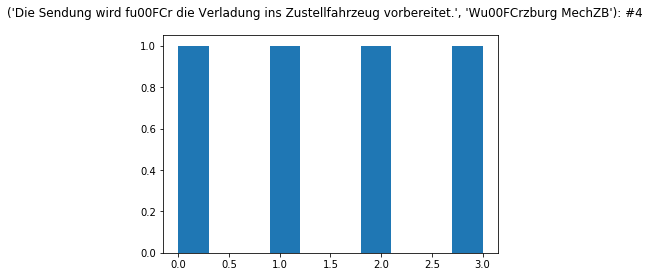

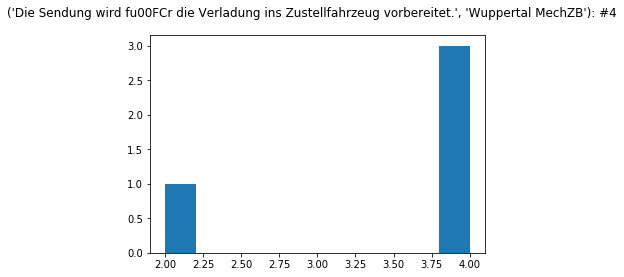

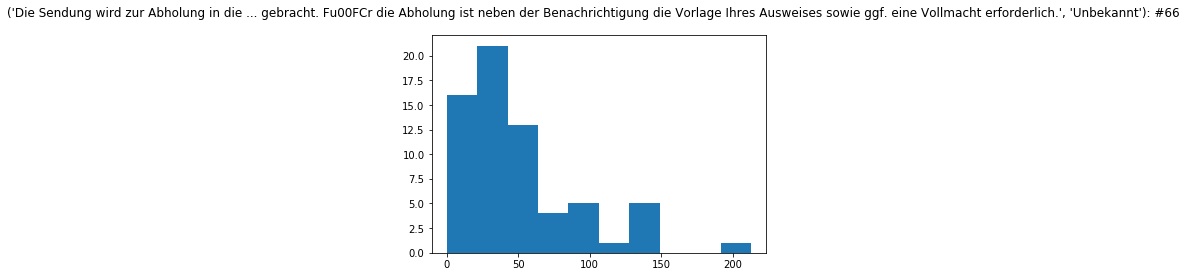

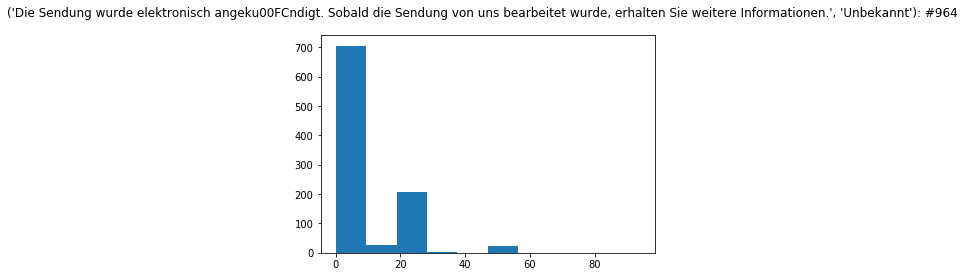

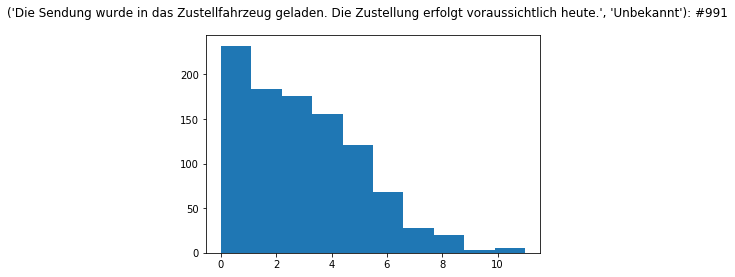

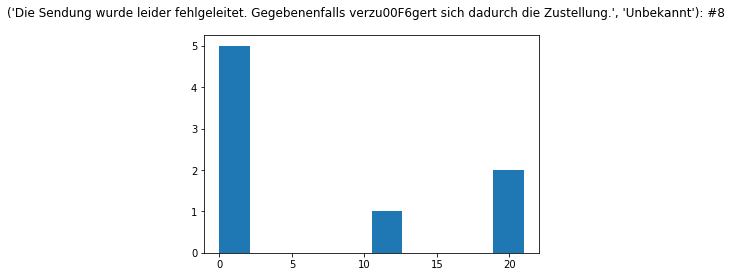

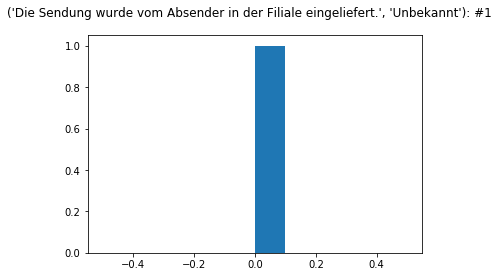

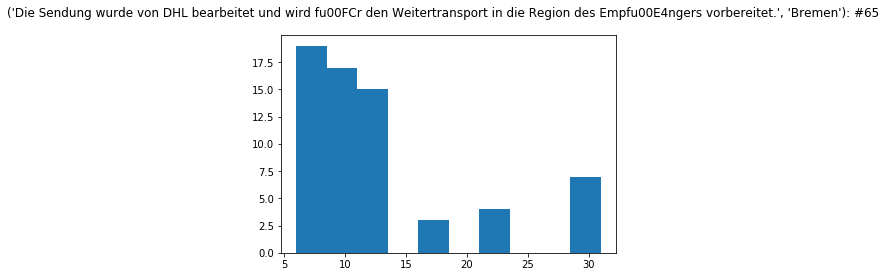

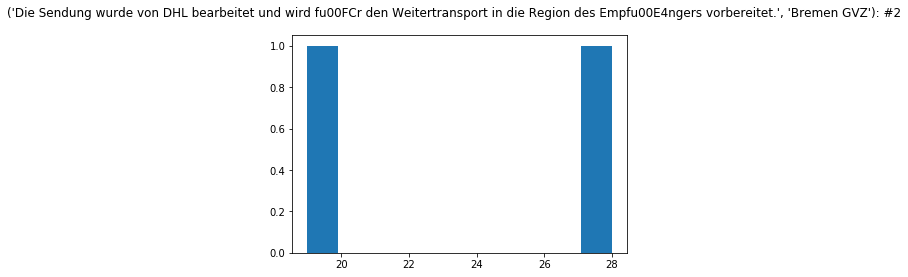

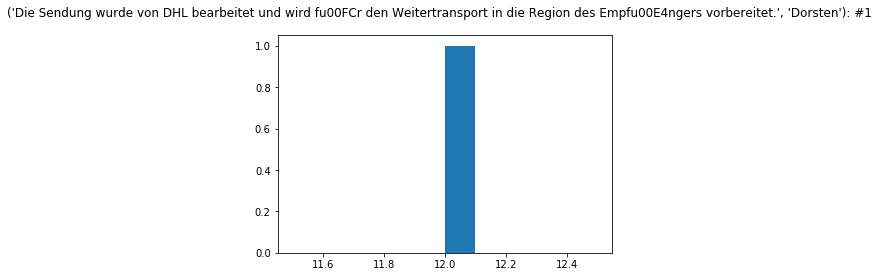

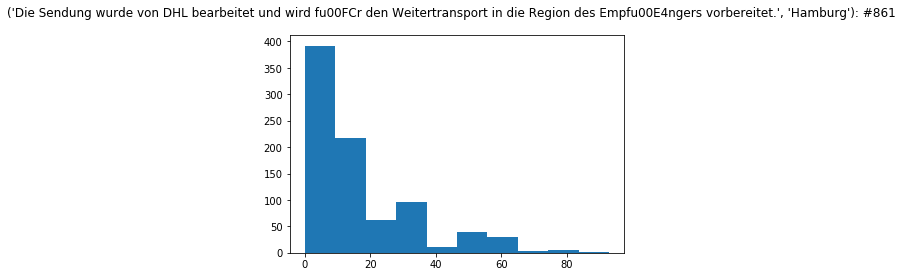

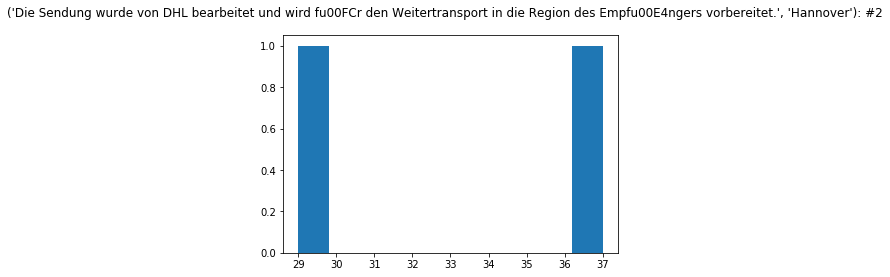

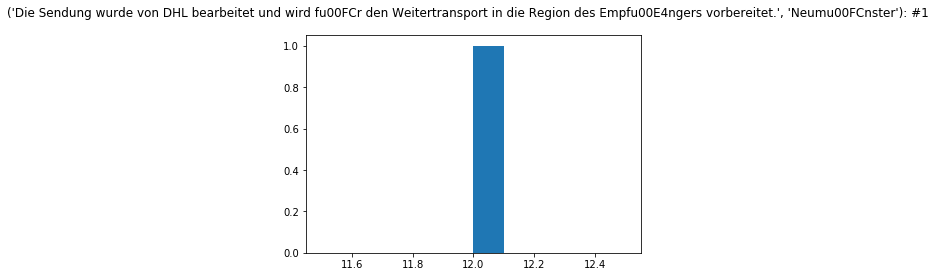

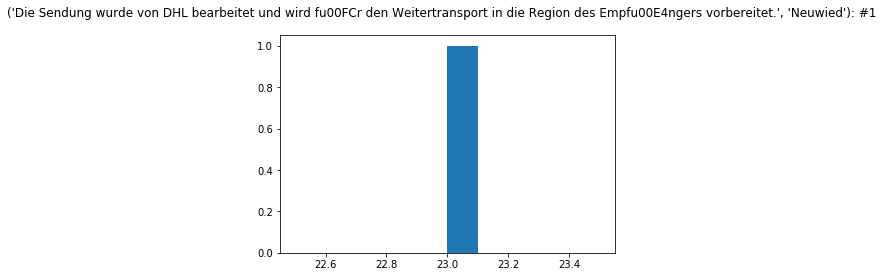

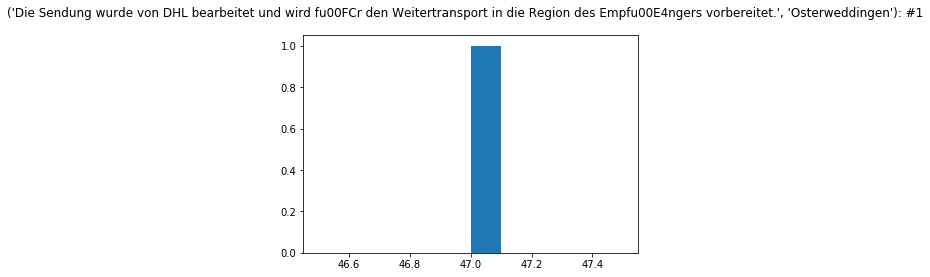

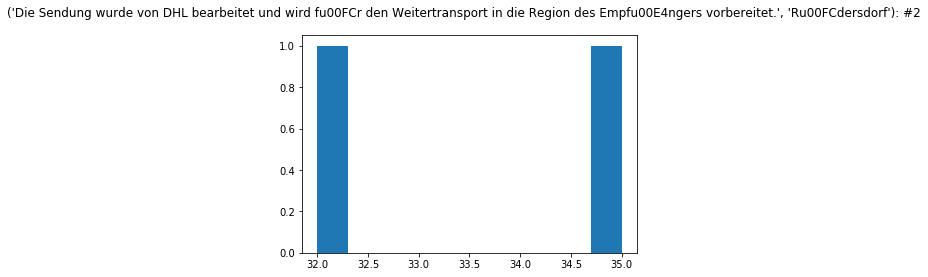

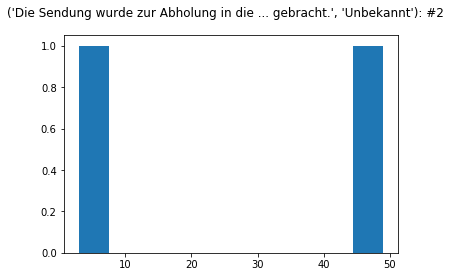

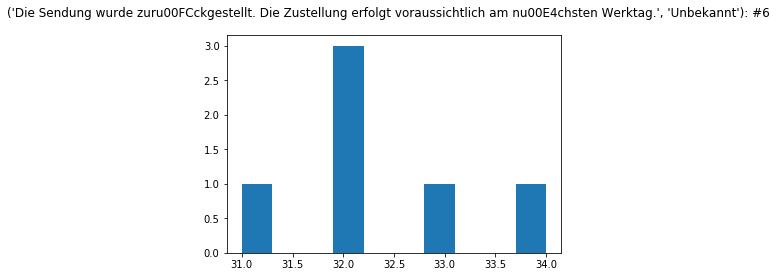

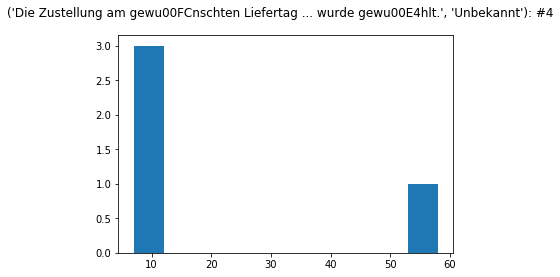

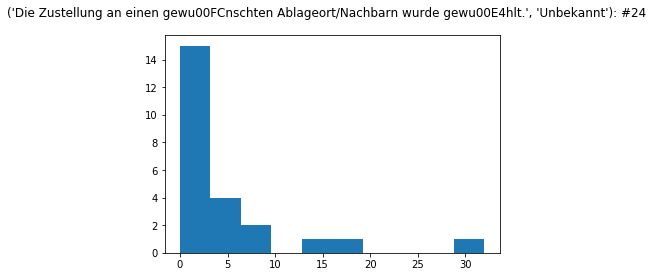

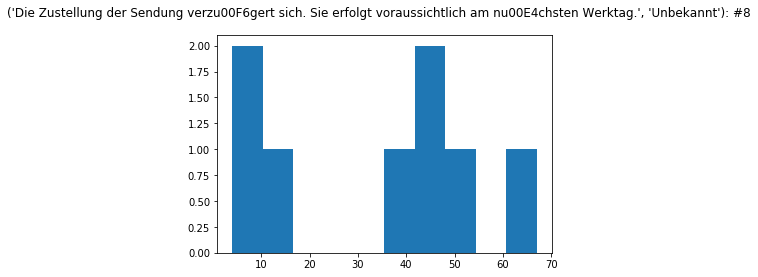

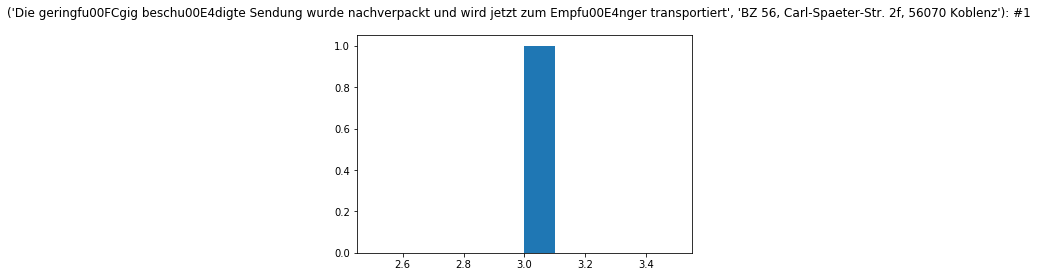

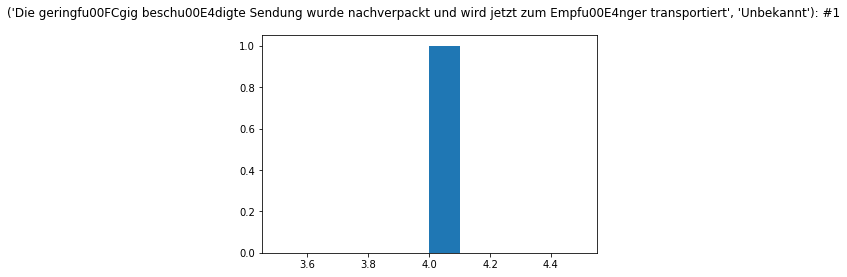

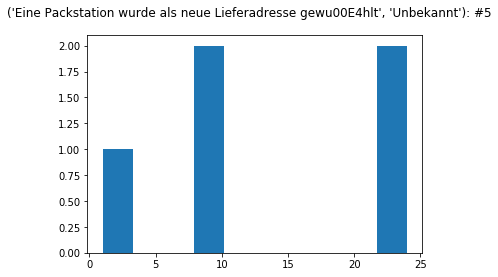

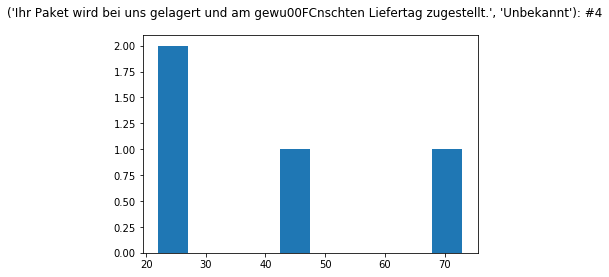

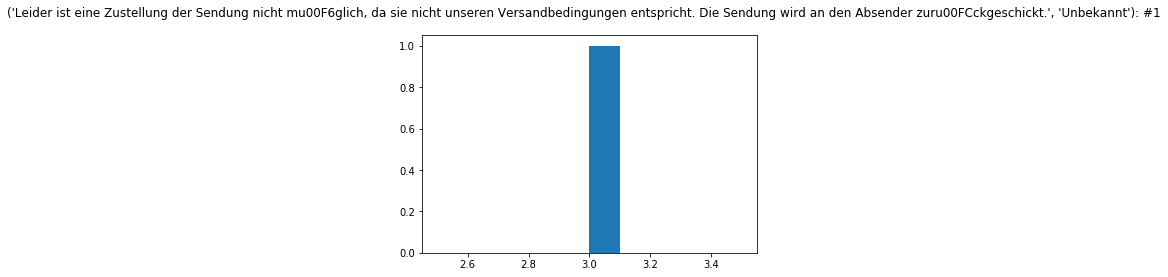

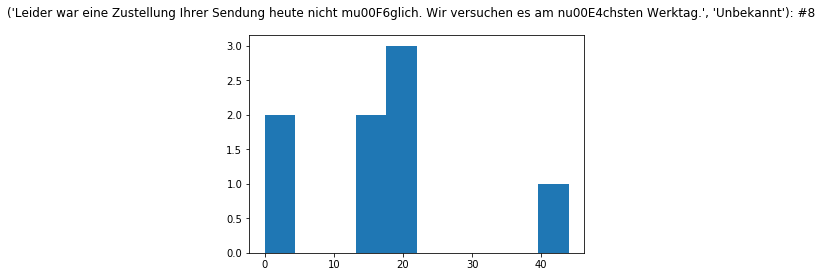

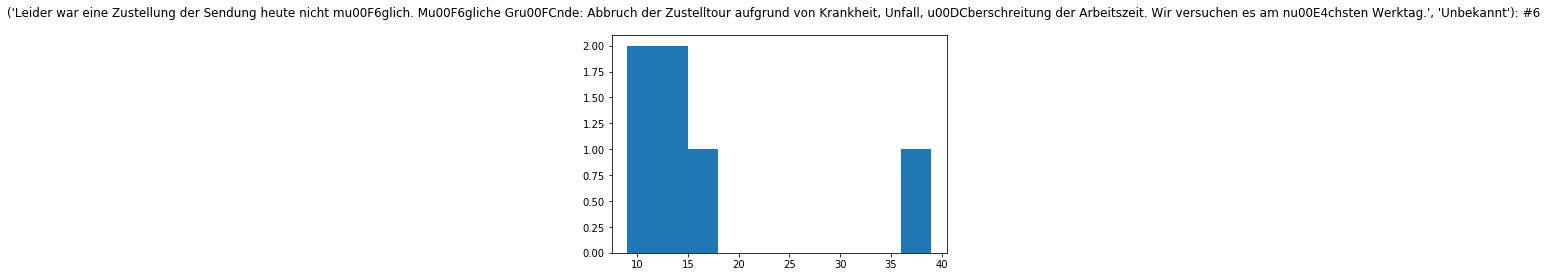

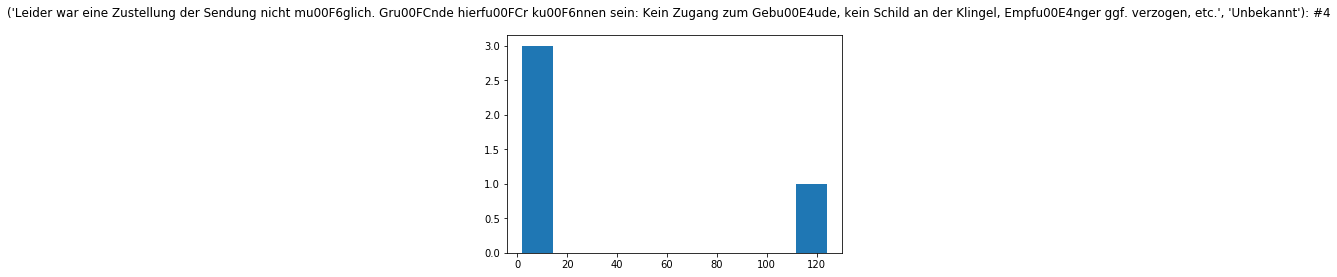

In [54]:
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline


grouped = df_temp.groupby(["status", "ort"])

for name, group in grouped:
    fig = plt.figure()
    fig.suptitle(str(name) + ": #{}".format(len(group)))
    matplotlib.pyplot.hist(group.datum_diff_h)
    plt.show()
    
df.drop(columns=["datum_diff_h"], inplace=True)

In [55]:
df.head()

,shipment_number,datum,status,ort,is_final_event,status_next,ort_next,datum_next,datum_diff
0,00340434188193325701,2019-10-08 14:42:00+00:00,Die Sendung wurde elektronisch angeku00FCndigt...,Unbekannt,0.0,Die Sendung wurde von DHL bearbeitet und wird ...,Hamburg,2019-10-08 18:19:00+00:00,0 days 03:37:00
1,00340434188193325701,2019-10-08 18:19:00+00:00,Die Sendung wurde von DHL bearbeitet und wird ...,Hamburg,0.0,Die Sendung ist in der Region des Empfu00E4nge...,Saulheim,2019-10-09 02:44:00+00:00,0 days 08:25:00
2,00340434188193325701,2019-10-09 02:44:00+00:00,Die Sendung ist in der Region des Empfu00E4nge...,Saulheim,0.0,Die Sendung wurde in das Zustellfahrzeug gelad...,Unbekannt,2019-10-09 07:46:00+00:00,0 days 05:02:00
3,00340434188193325701,2019-10-09 07:46:00+00:00,Die Sendung wurde in das Zustellfahrzeug gelad...,Unbekannt,0.0,Die Sendung wurde erfolgreich zugestellt.,Unbekannt,2019-10-09 10:35:00+00:00,0 days 02:49:00
4,00340434188193325701,2019-10-09 10:35:00+00:00,Die Sendung wurde erfolgreich zugestellt.,Unbekannt,1.0,SuccessDelivery,SuccessDelivery,2019-12-04 00:00:00+00:00,55 days 13:25:00
